In [1]:
!nvidia-smi

Sun Mar 27 08:30:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install transformers==4.0.1

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
     |████████████████████████████████| 2.9 MB 39.2 MB/s 


In [4]:
!pip install torch==1.4.0

     |████████████████████████████████| 753.4 MB 6.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [5]:
import torch
import random
import numpy as np
torch.cuda.is_available()

True

In [6]:
config = {
    'train_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/train.csv',
    'test_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/test.csv',
    'train_val_ratio':0.1,
    'model_path':'/content/drive/MyDrive/Colab Notebooks/dataset/BERT_model',
    'batch_size':16,
    'head': 'cnn',
    'num_epochs':1,
    'learning_rate':2e-5,
    'logging_step':500,
    'seed':2022
}
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

seed_everything(config['seed'])

2022

## defaultdict
defaultdict的作用是在于，当字典里的key不存在但被查找时，返回的不是keyError而是一个默认值：

举例
dict1 = defaultdict(int)

dict2 = defaultdict(set)

dict3 = defaultdict(str)

dict4 = defaultdict(list)

print(dict1[1])，print(dict2[1])，print(dict3[1])，print(dict4[1])

0


set()

<br /> 

[]


## Python3.6 之 f'{}'
F字符串是开头有一个f的字符串文字，以及包含表达式的大括号将被其值替换。表达式在运行时进行渲染，然后使用__format__协议进行格式化。

举例：

name = "Eric"

age = 74

f"Hello, {name}. You are {age}."

'Hello, Eric. You are 74.'

## np.unique()

该函数是去除数组中的重复数字，并进行排序之后输出。


In [7]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
def read_data(config, tokenizer, mode = 'train'):
    data_df = pd.read_csv(config[f'{mode}_file_path'], sep=',')
    if mode == 'train':
        # 如果是训练文件 则划分训练集、验证集 【验证集(validation set)】
        X_train, y_train = defaultdict(list),[]
        X_val, y_val = defaultdict(list),[]
        num_val = int(len(data_df) * config['train_val_ratio'])
    else:
        #只生成测试集
        X_test, y_test = defaultdict(list),[]
        
        
    for i, row in tqdm(data_df.iterrows(), desc=f'preprocess {mode} data', total =len(data_df)):
        #得到每个句子的标签
        label = row[1] if mode == 'train' else 0
        #得到每个句子
        sentence = row[-1]
        # add_special_tokens 添加一些特殊的toke： CLS、 SEP
        # return_token_type_ids 返回每个词所对应的id
        # return_attention_mask 批量时， padding部分无需注意
        inputs = tokenizer.encode_plus(sentence, add_special_tokens = True, return_token_type_ids =True, return_attention_mask = True )
        #print("inputs:", inputs)
        #一个 inputs中:
        #inputs: {'input_ids': [101, 677, 6440, 3198, 2110, 4495, 2797, 3322, 1510, 702, 679, 977, 8024, 5439, 2360, 671, 2584, 722, 678, 2828, 2797, 3322, 3035, 749, 8024, 2157, 7270, 2897, 1355, 4873, 6375, 5439, 2360, 6608, 8024, 1920, 2157, 2582, 720, 4692, 2521, 6821, 4905, 752, 8043, 102], 
        #'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
        #'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
        # return：
        # input_ids；
        # token_type_ids
        # attention_mask
        if mode == 'train':
            if i < num_val:
                X_val['inputs_ids'].append(inputs['input_ids'])
                y_val.append(label)
                X_val['token_type_ids'].append(inputs['token_type_ids'])
                X_val['attention_mask'].append(inputs['attention_mask'])
            else:
                X_train['inputs_ids'].append(inputs['input_ids'])
                y_train.append(label)
                X_train['token_type_ids'].append(inputs['token_type_ids'])
                X_train['attention_mask'].append(inputs['attention_mask'])
                
        else:
                X_test['inputs_ids'].append(inputs['input_ids'])
                y_test.append(label) 
                X_test['token_type_ids'].append(inputs['token_type_ids'])
                X_test['attention_mask'].append(inputs['attention_mask'])
                
                
    if mode == 'train':
        label2id ={label: i for i, label in enumerate(np.unique(y_train))}
        #print("label2id",label2id)
        #label2id {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 106: 5, 107: 6, 108: 7, 109: 8, 110: 9, 112: 10, 113: 11, 114: 12, 115: 13, 116: 14}
        id2label ={i: label for label, i in label2id.items()}
        #print('id2label',id2label)
        #id2label {0: 100, 1: 101, 2: 102, 3: 103, 4: 104, 5: 106, 6: 107, 7: 108, 8: 109, 9: 110, 10: 112, 11: 113, 12: 114, 13: 115, 14: 116}
        y_train = torch.tensor([label2id[i] for i in y_train],dtype = torch.long)
        #print('y_train',y_train)
        #y_train tensor([ 3, 14,  6,  ...,  7,  6,  6])
        y_val = torch.tensor([label2id[i] for i in y_val],dtype = torch.long)
        return X_train, y_train, X_val, y_val, label2id, id2label
    
    else:
        y_test = torch.tensor(y_test, dtype = torch.long)
        return X_test,y_test        

## Dataset
* torch.utils.data.Dataset是代表自定义数据集方法的抽象类，你可以自己定义你的数据类继承这个抽象类，非常简单，只需要定义\_\_len\_\_和\_\_getitem\_\_ 这两个方法就可以。
* 通过继承torch.utils.data.Dataset的这个抽象类，我们可以定义好我们需要的数据类。当我们通过迭代的方式来取得每一个数据，但是这样很难实现取batch，shuffle或者多线程读取数据，所以pytorch还提供了一个简单的方法来做这件事情，通过torch.utils.data.DataLoader类来定义一个新的迭代器，用来将自定义的数据读取接口的输出或者PyTorch已有的数据读取接口的输入按照batch size封装成Tensor，后续只需要再包装成Variable即可作为模型的输入。

在torch.utils.data.Dataset和torch.utils.data.DataLoader这两个类中会用到python抽象类的魔法方法，包括\_\_len\_\_(self)，\_\_getitem\_\_(self)和\_\_iter\_\_(self)
* \_\_len\_\_(self) 定义当被len()函数调用时的行为（返回容器中元素的个数）
* \_\_getitem\_\_(self)定义获取容器中指定元素的行为，相当于self[key]，即允许类对象可以有索引操作。
* \_\_iter\_\_(self)定义当迭代容器中的元素的行为

## tensor size
行数：

tensor.size()[0]

or

tensor.size(0)

列数：

tensor.size()[1]

or

tensor.size(1)

举例：

a = torch.Tensor([[1,2,3],[4,5,6]])

s1 = a.size()[0]

s2 = a.size(0)

print(s1,'\n',s2)

输出： 

2 

2

In [8]:
from torch.utils.data import Dataset
class TNEWSData(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y 
    
    def __getitem__(self, idx):
        return {
            'inputs_ids': self.x['inputs_ids'][idx],
            'label': self.y[idx],
            'token_type_ids': self.x['token_type_ids'][idx],
            'attention_mask': self.x['attention_mask'][idx]
        }
    def __len__(self):
        #print("y:",self.y)
        #y: tensor([ 3, 14,  6,  ...,  7,  6,  6])
        #print('y.size:',self.y.size,'y.size(0):',self.y.size(0))
        #y.size: <built-in method size of Tensor object at 0x7fc76aaac140>(Tensor 对象的内置方法大小为 140494464794944) y.size(0): 48024
        return self.y.size(0)

从TNEWSData返回的一个example 
     
        {
            'inputs_ids' : self.x['inputs_ids'][idx],
            'label' : self.y[idx],
            'token_type_ids': self.x['token_type_ids'][idx],
            'attention_mask': self.x['attention_mask'][idx]
            
        }
        
        
取多次 examples，使用collate_fn整合到一起，变成一个tensor, 以便并行加载

In [9]:
def collate_fn(example):
    #从 TNEWData 返回的{}中，多了两个key：token_type_ids、attention_mask
    input_ids_list = []
    labels = []
    token_type_ids_list = []
    attention_mask_list = []
    
    for ex in example:
        input_ids_list.append(ex['inputs_ids'])
        labels.append(ex['label'])
        token_type_ids_list.append(ex['token_type_ids'])
        attention_mask_list.append(ex['attention_mask'])
    
    #对齐放入tensor
    max_len = max(len(input_ids) for input_ids in input_ids_list)
    # shape (len(labels), max_length)
    input_ids_tensor = torch.zeros((len(labels), max_len), dtype=torch.long)
    # torch.zeros_like:生成和括号内变量维度维度一致的全是零的内容
    token_type_ids_tensor = torch.zeros_like(input_ids_tensor)
    attention_mask_tensor = torch.zeros_like(input_ids_tensor)
    
    
    # 把列表中的数据放入tensor里
    for i, input_ids in enumerate(input_ids_list):
        #print('len(input_ids):',len(input_ids))
        #每次循环input_ids长度不同
        #len(input_ids): 18
        #len(input_ids): 30
        #len(input_ids): 21
        #len(input_ids): 27
        input_ids_tensor[i, :len(input_ids)] = torch.tensor(input_ids, dtype = torch.long)
        #print('input_ids_tensor',input_ids_tensor)
        token_type_ids_tensor[i, :len(input_ids)] = torch.tensor(token_type_ids_list[i], dtype= torch.long)
        attention_mask_tensor[i, :len(input_ids)] = torch.tensor(attention_mask_list[i], dtype= torch.long)
        
        
    return {
        'input_ids': input_ids_tensor,
        'labels': torch.tensor(labels, dtype = torch.long),
        'token_type_ids': token_type_ids_tensor,
        'attention_mask':  attention_mask_tensor
    }

input_ids_tensor：

tensor([[ 101, 2207, 3301, 1351, 4514,  749, 1372, 4344, 8024, 1316, 6158, 5439,
         2360, 6842, 1726, 8024, 2157, 7270,  671, 4692, 5010, 1139,  749, 1898,
          102,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 7674, 1947, 2791, 6587, 1164, 4372, 6632, 3341, 6632, 7770,  702,
          782, 6579, 2791, 3339, 3327, 4372, 3227, 5865,  678, 7360,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2398, 2128, 2544, 6134, 2658, 6399, 1166, 2825, 3318, 7309, 7959,
          157, 8882, 1744, 7354, 4993, 6612,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 3805, 2255, 1277, 2199, 2456, 2276, 2422, 2141, 7741, 2110, 3413,
         3173, 3413, 1277, 8013, 7564, 6369,  127, 3299, 2419, 1184, 2458, 2339,
         8013,  102,    0,    0,    0,    0,    0,    0],
        [ 101, 3342, 1283, 2079, 3198, 7392, 8126, 2399, 7028, 1726, 9312, 2864,
         1196, 8024, 1086, 2428,  680, 7942, 3856, 4197, 3022, 3440, 7652, 4028,
         1923, 1988, 8013,  102,    0,    0,    0,    0],
        [ 101, 4886, 4294, 1591, 6413, 3315, 4506, 8038, 7414, 7323, 1377, 3140,
          679, 6206, 5632, 1429,  924, 7730, 2844, 5661, 1372, 2897,  162, 1220,
         1213, 3341, 2773, 5885, 6832, 3616, 8043,  102],
        [ 101, 1306, 3694, 1344,  691, 1814, 2110, 3413, 1724, 2399, 5277, 1063,
         4408, 6958, 2760,  133,  517, 7028, 3941, 3765,  671, 3189, 3952, 6381,
          518,  135,  102,    0,    0,    0,    0,    0],
        [ 101, 6237, 3123, 1092, 2773, 3322, 5312, 7607,  704, 1744, 1378, 3968,
         5401, 1744, 1348, 6663, 1139, 3341,  100, 1353, 2190,  100,  749,  102,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 8109, 2399, 1059, 1744, 4636, 2487, 1814, 2356, 2408,  691, 3300,
         1126, 2429, 1814, 2356,  677, 3528, 8043,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  711,  862, 6821, 2429, 3189, 3315, 2207, 2270, 5543, 6375, 1059,
         4413, 5686, 3318, 5106,  692,  751, 4685, 1184, 2518, 8043,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2496, 4906, 3683, 4775,  678, 8424, 1146, 1400, 1071,  800,  782,
         6963, 6432,  749,  784,  720, 8043, 5687, 2472, 6849, 4994, 2828, 4281,
         1430, 2533, 1922, 1920,  749,  102,    0,    0],
        [ 101,  803, 2289, 1366, 3333, 3333, 3696, 4638, 2401, 4886, 4495, 3833,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  100, 5698, 7937, 2458, 7305,  100, 5143, 1154, 4638, 1045, 4817,
         1168, 2419, 3221,  679, 3221, 3633, 4276, 1450, 8043,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  671, 5663, 6963, 2523, 2208, 3300,  782, 6432, 4638, 1091,  868,
         2825, 2341,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

## BertTokenizer
BERT分词器

## from_pretrained
一般建议直接使用from_pretrained()方法加载已经预训练好的模型或者参数。
* from_pretrained() let you instantiate a model/configuration/tokenizer from a pretrained version either provided by the library itself (currently 27 models are provided as listed here) or stored locally (or on a server) by the user


In [10]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
def build_dataloader(config):
    #加载词表
    tokenizer = BertTokenizer.from_pretrained(config['model_path'])
    X_train, y_train, X_val, y_val, label2id, id2label = read_data(config, tokenizer, mode='train')
    X_test, y_test = read_data(config, tokenizer, mode='test')
    
    train_dataset = TNEWSData(X_train, y_train)
    val_dataset=TNEWSData(X_val, y_val)
    test_dataset = TNEWSData(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=False, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=False, collate_fn=collate_fn)
    
    
    return train_dataloader, val_dataloader, test_dataloader, id2label

In [11]:
train_dataloader, val_dataloader, test_dataloader, id2label = build_dataloader(config)

preprocess test data: 100%|██████████| 10000/10000 [00:05<00:00, 1865.59it/s]


In [12]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[  101,  6821,  3613,  7413,  2128,   782,  2218,   689,  3300,  2361,
          3307,   749,  8043,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,   898,  5101,  2434,  8038,  8711,  2199,   711,   689,  1218,
          2372,  3341,  2342,  1920,  2356,  1767,  4958,  7313,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  8137, 12675,  7721,  6852,  5664,  3683,   722,  1184,  3300,
          1525,   763,  2825,  3318,  4960,  4788,  8043,  1469,  8137,  8144,
          5143,  1154,  3683,  8024,  3221,  1059,  7481,  4638,   102,     0,
             0,     0],
        [  101,  4510,  4828,  2486,  2198,  8013,   808,  6205,  3175,  4156,
          7222,  8024,  7716,   836,  3209,  8038,   704,  1744, 11400,  1798,
          5661,  3678,  2825,  3318,  7566,  

## argmax
（1）torch.argmax(input, dim=None, keepdim=False)返回指定维度最大值的序号；

（2）dim给定的定义是：the demention to reduce.也就是把dim这个维度的，变成这个维度的最大值的index。

具体访问：https://blog.csdn.net/zouxiaolv/article/details/120905579?spm=1001.2101.3001.6650.7&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-7.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-7.pc_relevant_default&utm_relevant_index=9

## f1_score average
1.'binary': 只报告指定的类的结果。 这仅适用于target() 是 binary.pos_labely_{true,pred}

2.'micro':通过计算真阳性、假阴性和假阳性的总数来全局计算指标。

3.'macro':计算每个标签的指标，并找到它们的未加权平均值。 这没有考虑标签不平衡。

4.'weighted'：计算每个标签的指标，并通过支持（每个标签的真实实例数）找到它们的平均加权。 这会改变“宏观”以解决标签不平衡问题； 它可能导致 F 分数不在精确率和召回率之间。

5.'samples':计算每个实例的指标，并找到它们的平均值（仅对不同于 accuracy_score 的多标签分类有意义）。

In [13]:
from sklearn.metrics import f1_score
def evaluation(config, model, val_dataloader):
    model.eval()
    preds = []
    labels = []
    val_loss = 0.
    val_iterator = tqdm(val_dataloader, desc='Evaluation', total=len(val_dataloader))
    
    with torch.no_grad():
        for batch in val_iterator:
            labels.append(batch['labels'])
            #放入GPU
            batch = {item: value.to(config['device']) for item, value in batch.items()}
            #print('batch是：',batch)
            loss, logits = model(**batch)[:2]
            #print('loss是：',loss,'logits是：',logits)
            #loss是： tensor(1.6093, device='cuda:0') 
            val_loss += loss.item()# item是得到一个元素张量里面的元素值
            preds.append(logits.argmax(dim = -1).detach().cpu())
            
    avg_val_loss = val_loss / len(val_dataloader)
    labels = torch.cat(labels, dim = 0).numpy()
    preds = torch.cat(preds, dim=0).numpy()
    f1 = f1_score(labels, preds, average='macro')
    #average{‘micro’, ‘macro’, ‘samples’,’weighted’, ‘binary’} or None, default=’binary’
    return avg_val_loss, f1

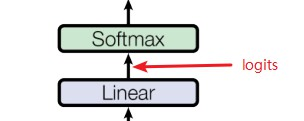

## batch是：
         {'input_ids': tensor([[ 101,  677, 6440, 3198, 2110, 4495, 2797, 3322, 1510,  702,  679,  977,
         8024, 5439, 2360,  671, 2584,  722,  678, 2828, 2797, 3322, 3035,  749,
         8024, 2157, 7270, 2897, 1355, 4873, 6375, 5439, 2360, 6608, 8024, 1920,
         2157, 2582,  720, 4692, 2521, 6821, 4905,  752, 8043,  102],
        [ 101, 1555, 6617, 4384, 4413, 5500,  819, 3300, 7361, 1062, 1385, 1068,
          754, 2454, 3309, 1726, 1908,  677, 3862, 6395, 1171,  769, 3211, 2792,
         2190, 1062, 1385, 8109, 2399, 2399, 2428, 2845, 1440, 4638,  752, 1400,
         2144, 3417, 7309, 6418, 1141, 4638, 1062, 1440,  102,    0],
        [ 101, 6858, 6814,  704,  792, 1062, 1385,  743,  749,  753, 2797, 2791,
         8024, 7674,  802, 6963,  802,  749, 8024, 4385, 1762, 1297, 2157,  679,
         2682, 1297,  749,  511, 2582,  720, 1905, 4415, 8043,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 8271, 2399, 1343,  915, 5384, 3172, 4692,  686, 4518, 3344, 2533,
         5709, 1914, 2208, 7178, 8043,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1178, 7557, 1143, 4638,  702, 2595, 7484, 3173, 8024, 7440, 3209,
         4633, 1921, 4344, 2137, 1169, 4276, 3173, 1501, 7674, 1355,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1086, 3613, 6395, 3209,  749,  100, 3187, 3127, 3221, 1914,  720,
         2163, 2174,  100,  100,  100, 6847, 1921, 4638,  704, 1744,  728,  729,
         4413, 7339, 8013,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  676, 1093, 4688, 8945, 8860,  118, 1059, 4413, 7674,  702, 2972,
         1139, 8038,  757, 5468, 5381,  116, 1277, 1779, 7216,  116, 1093,  772,
         1501, 4638, 4510, 1555, 2398, 1378,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 7028,  976, 8549, 3173, 5739, 7413, 8043, 1071, 2141, 7028,  976,
         2190, 3274, 7434, 3341, 6432, 1398, 3416, 7028, 6206,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1963,  862, 1762, 1555,  689, 3833, 1220,  704,  679, 1358,  782,
         3619, 7745, 8043,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 8467, 4276, 5273, 3517, 3457, 3297, 3946, 3382, 4638, 1724,  702,
          703, 7781, 8024, 2034, 6443, 6963, 3221,  671, 4495, 4638, 4886, 3698,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1119,  756, 4777, 1355, 4638, 1744,  772,  697, 6762, 4510, 1220,
         6756, 2582,  720, 3416, 8024, 3300,  784,  720, 2661, 1599, 8043,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2791, 1765,  772, 4925, 6826, 6826, 3187, 3791, 1139, 1378, 8043,
         1925, 6121, 4777, 4955, 2229, 2229, 7270, 2528, 2566, 6821, 3416, 6432,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2769, 1724, 1283,  671,  702, 3299, 8024, 5439, 2038,  671, 1283,
          758,  671,  702, 3299, 8024, 2100, 3621, 1061,  674,  684, 3300,  697,
         2207, 2111, 8024, 3221, 1044,  743, 2791, 6820, 3221, 1044,  743, 6756,
         8043,  102,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  100,  772, 1765, 1215, 2245,  100, 3563, 2466,  711,  100,  691,
         5806, 1169, 6863,  100, 6843, 1158, 3173, 2658, 2845,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1059, 1744, 7674,  702, 1925, 1765, 6084, 1394, 2398, 1378, 1762,
         3772, 5862, 1765,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 3125,  752, 8038, 1155,  712,  818, 2456, 4343, 1767,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       device='cuda:0'), 'labels': tensor([ 7,  4,  5, 10,  8,  3,  8, 14,  3,  1,  8,  5,  6,  4,  4,  0],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

## logits是： 
        tensor([[-4.5495e-01,  3.9138e-01,  2.8412e-01, -1.3348e-01, -9.8686e-02,
         -5.0656e-01, -3.6257e-01,  3.7944e+00,  4.3732e-01, -6.3327e-01,
         -9.1802e-01, -2.3124e-01, -1.2092e+00, -1.2817e-01, -2.1047e-01],
        [-6.7320e-01, -1.2972e+00, -1.1877e+00, -9.7854e-01,  3.1744e+00,
         -5.7041e-02, -7.8419e-01, -9.8226e-01,  1.4663e+00, -4.7662e-01,
         -1.0516e+00, -2.8617e-01,  1.4924e+00, -2.6537e-01, -1.0275e+00],
        [ 1.4523e-01, -6.9144e-01, -4.0083e-01, -6.0272e-01,  1.2405e+00,
          4.2067e+00, -1.7844e-01,  1.5162e-02,  4.9610e-01, -8.8375e-01,
         -9.0649e-02, -8.0009e-01, -2.4050e-01,  1.6777e-01, -1.1519e+00],
        [-1.0005e+00, -6.5296e-01,  2.1261e-02,  2.4762e+00, -2.4718e-01,
         -1.4478e+00, -2.8287e-01, -5.7907e-01, -1.7646e-01,  8.4744e-01,
          5.6884e-01,  2.5697e+00, -1.2265e+00, -1.0800e+00,  4.5676e-01],
        [-1.7715e+00, -5.0277e-01,  1.9078e-01, -7.2128e-01,  3.9818e-01,
         -1.0294e+00,  2.5774e+00, -2.7246e-01,  2.8189e+00, -5.9635e-01,
         -4.5280e-01, -2.8777e-01, -1.8522e+00, -1.0400e+00,  1.1921e+00],
        [-7.4333e-01, -4.5764e-01,  1.3148e+00,  3.7047e+00, -5.9233e-01,
         -1.6101e+00, -6.5272e-01,  7.5756e-02, -2.8207e-01,  3.4266e-01,
         -6.6282e-01,  1.7815e-01, -8.8283e-01, -6.1222e-01,  1.3032e+00],
        [-1.3940e+00, -8.4028e-01, -1.2991e+00, -1.4102e+00,  2.4425e+00,
          6.1442e-03, -7.2514e-01, -7.6695e-01,  2.2364e+00, -1.2186e+00,
         -4.4609e-01, -5.2918e-01, -8.9835e-01,  1.7127e+00, -4.4093e-01],
        [-1.3116e+00, -3.6532e-01,  4.9940e-01,  4.6601e-01, -6.4636e-01,
         -1.7763e+00, -6.8133e-02, -6.3061e-01,  1.0420e+00, -2.7271e-01,
         -7.3562e-01, -6.1928e-01, -8.2941e-01, -9.7183e-01,  4.4418e+00],
        [-1.2365e+00, -5.4215e-02, -1.5820e-01, -6.3942e-01,  1.9113e+00,
          3.4430e-01,  4.1767e-01,  9.0720e-01,  1.9011e+00, -3.7981e-01,
         -5.0475e-01, -5.3904e-01, -1.2614e+00, -3.3815e-01, -6.1433e-01],
        [ 1.4004e+00,  2.4593e+00,  2.8613e+00, -4.6119e-01, -6.5806e-01,
         -8.5080e-01, -2.1880e-01,  1.3030e-01, -1.2848e+00, -2.8939e-01,
         -2.5623e-01, -4.1265e-01, -1.0264e+00,  2.8124e-01,  1.1444e-01],
        [-1.2705e+00, -6.4217e-01, -5.0907e-01, -6.7020e-01,  1.8835e-02,
         -7.8704e-01,  4.5332e+00, -5.7493e-01,  1.6277e+00, -3.0948e-02,
         -5.2277e-01,  6.6761e-02, -9.3418e-01, -8.8416e-01,  2.4252e-01],
        [-9.3446e-01, -1.1604e+00, -1.1363e+00, -8.5872e-01,  2.2835e+00,
          3.4046e+00, -4.0466e-01, -4.6878e-01,  8.3369e-01, -7.2615e-01,
         -5.0898e-01, -7.8497e-01,  4.2499e-01,  6.5443e-02, -1.0163e+00],
        [ 2.3607e+00, -4.5655e-01,  6.1696e-01, -6.6886e-01,  1.3091e+00,
          1.7759e+00, -8.9774e-01, -1.1319e-01, -8.7473e-02, -7.3989e-01,
         -7.8213e-01, -2.2515e-03, -3.5253e-01,  3.7553e-01, -1.1525e+00],
        [-1.3104e+00, -4.2189e-01, -1.5128e+00, -1.5202e+00,  2.4152e+00,
          5.0636e-01, -7.4861e-01, -5.5458e-02,  9.2752e-01, -1.0806e+00,
          7.9444e-02, -7.7264e-01, -6.3976e-01,  2.4397e+00, -1.0669e+00],
        [-1.1987e+00, -9.4985e-01, -8.9236e-01, -5.3275e-01,  1.9583e+00,
          3.4641e+00, -3.7244e-01,  2.8553e-01,  8.5572e-01, -1.1244e+00,
          2.4201e-01, -1.1572e+00, -1.1993e-01,  4.4837e-01, -9.1884e-01],
        [ 1.2498e-01,  1.4287e+00,  3.8391e-01, -7.2719e-01, -8.6678e-02,
         -5.9516e-01, -5.9600e-01,  1.9743e+00, -6.6604e-01, -5.3793e-01,
          1.6101e-01, -4.0244e-01, -1.4250e+00,  2.2168e+00, -3.8022e-01]],
       device='cuda:0')

## trange
trange(i) 是 tqdm(range(i)) 的简单写法

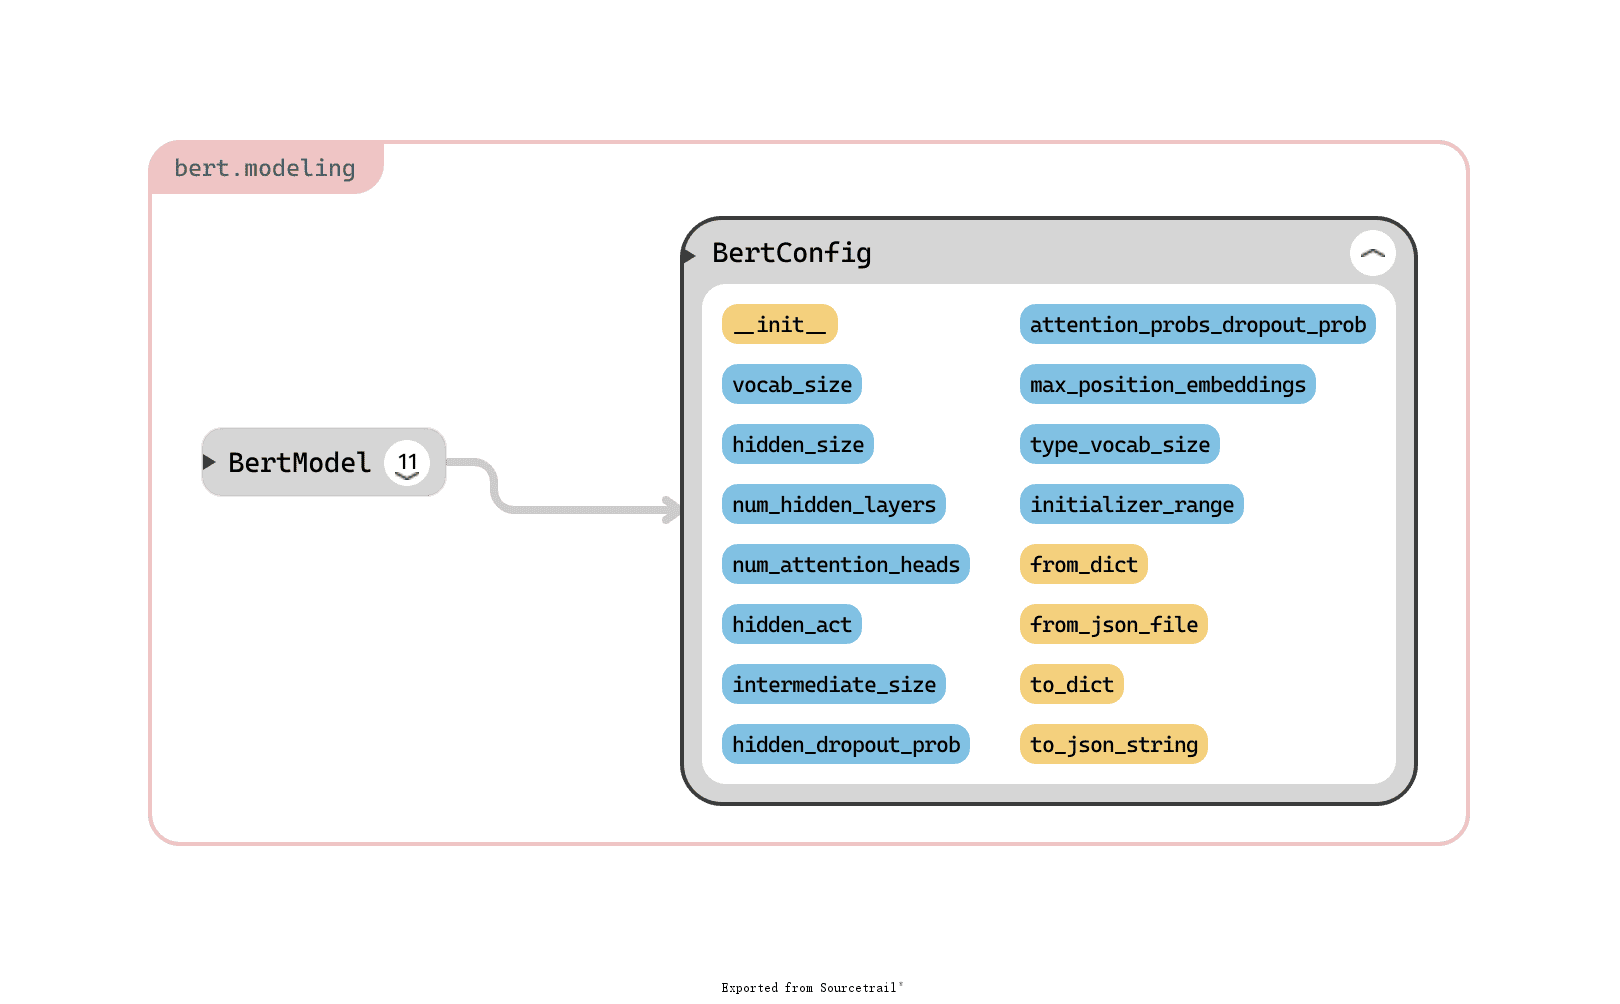
**参数**
* vocab_size：词汇表大小。
* hidden_size=768：encoder 层和 pooler 层大小。这实际上就是 embedding_size，BERT 干的事情就是不停地优化 embedding。。。
* num_hidden_layers=12：encoder 中隐层个数。
* num_attention_heads=12：每个 attention 层的 head 个数。
* intermediate_size=3072：中间层大小。
* hidden_act="gelu"：隐层激活函数。
* hidden_dropout_prob=0.1：所有全连接层的 dropout 概率，包括 embedding 和 pooler。
* attention_probs_dropout_prob=0.1：attention 层的 dropout 概率。
* max_position_embeddings=512：最大序列长度。
* type_vocab_size=16：token_type_ids 的词汇表大小。
* initializer_range=0.02：初始化所有权重时的标准差。
方法
* from_dict(cls, json_object)：从一个字典来构建配置。
* from_json_file(cls, json_file)：从一个 json 文件来构建配置。
* to_dict(self)：将配置保存为字典。
* to_json_string(self)：将配置保存为 json 字符串。

## BertForSequenceClassification 
是在 BertModel 的基础上，添加了一个线性层 + 激活函数，用于分类。

In [14]:
# train BERT
from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW
from tqdm import trange

def train(config, id2label, train_dataloader, val_dataloader):
    #配置文件
    bert_config = BertConfig.from_pretrained(config['model_path'])
    bert_config.num_labels = len(id2label)
    model = BertForSequenceClassification.from_pretrained(config['model_path'], config = bert_config)
    

    #优化器
    optimizer = AdamW(model.parameters(), lr = config['learning_rate'])
    
    #放入GPU
    model.to(config['device'])
    epoch_iterator = trange(config['num_epochs'])
    global_steps = 0
    train_loss = 0.
    logging_loss =0.
    
    #跑了几个迭代
    for epoch in epoch_iterator:
        train_iterator = tqdm(train_dataloader, desc='Training', total=len(train_dataloader))
        model.train()
        for batch in train_iterator:
            #字典中的value送入GPU
            batch = {item: value.to(config['device']) for item, value in batch.items()}
                        
            #将字典作为关键字参数传递给python中函数
            loss = model(**batch)[0]
            #print('train中的loss为：',loss)
            #train中的loss为： tensor(2.8556, device='cuda:0', grad_fn=<NllLossBackward>)

            #模型参数梯度设置为0
            model.zero_grad()
            
            #反向传播
            loss.backward()
            
            #更新参数
            optimizer.step()
            
            #叠加loss
            train_loss += loss.item()
            global_steps += 1
            
            if global_steps % config['logging_step'] == 0:
                print_train_loss = (train_loss - logging_loss) / config['logging_step']
                
                logging_loss = train_loss
                
                avg_val_loss, f1 = evaluation(config, model, val_dataloader)
                
                print_log = f'>>> training loss: {print_train_loss: .5f}, val loss: {avg_val_loss: .5f}, valid f1 score: {f1: .5f}'
                #print_log = f'>>> training loss: {print_train_loss:.4f}, valid loss: {avg_val_loss:.4f}, ' \
                 #           f'valid f1 score: {f1:.4f}'
                print(print_log)
                model.train()
    return model

In [15]:
model = train(config, id2label, train_dataloader, val_dataloader)

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/dataset/BERT_model were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

>>> training loss:  1.67589, val loss:  1.40506, valid f1 score:  0.49810



Training:  33%|███▎      | 999/3002 [04:43<08:38,  3.86it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:38,  3.38it/s]

Evaluation:   1%|          | 3/334 [00:00<00:45,  7.23it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:33,  9.71it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.65it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:24, 13.21it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:24, 13.01it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 13.36it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:22, 14.17it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:22, 13.86it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:22, 13.99it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 14.10it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:22, 13.69it/s]

Evaluation:   7%|▋         | 25/334 [00:01<00:22, 13.93it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:22, 13.40it/s]

Evaluation:   9%|▊   

>>> training loss:  1.39974, val loss:  1.32729, valid f1 score:  0.51108



Training:  50%|████▉     | 1499/3002 [07:19<06:33,  3.82it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:34,  3.52it/s]

Evaluation:   1%|          | 3/334 [00:00<00:44,  7.41it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:35,  9.39it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.48it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.73it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.87it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 13.14it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.59it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.44it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.51it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 13.67it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:22, 13.57it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.80it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 13.20it/s]

Evaluation:   9%|▊  

>>> training loss:  1.33853, val loss:  1.30054, valid f1 score:  0.50337



Training:  67%|██████▋   | 1999/3002 [09:54<04:19,  3.86it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:39,  3.35it/s]

Evaluation:   1%|          | 3/334 [00:00<00:44,  7.48it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:34,  9.59it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.50it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.66it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.86it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 13.17it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.82it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.56it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.69it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 13.98it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.50it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.60it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 12.92it/s]

Evaluation:   9%|▊  

>>> training loss:  1.29104, val loss:  1.28715, valid f1 score:  0.54241



Training:  83%|████████▎ | 2499/3002 [12:30<02:19,  3.60it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:32,  3.58it/s]

Evaluation:   1%|          | 3/334 [00:00<00:45,  7.31it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:33,  9.68it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:27, 11.69it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:24, 13.21it/s]

Evaluation:   3%|▎         | 11/334 [00:00<00:24, 13.33it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:23, 13.45it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.85it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.51it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.65it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 13.74it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.46it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.49it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 13.20it/s]

Evaluation:   9%|▊  

>>> training loss:  1.30153, val loss:  1.27490, valid f1 score:  0.53048



Training: 100%|█████████▉| 2999/3002 [15:05<00:00,  3.93it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:41,  3.29it/s]

Evaluation:   1%|          | 3/334 [00:00<00:45,  7.35it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:33,  9.85it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:27, 11.78it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:24, 13.21it/s]

Evaluation:   3%|▎         | 11/334 [00:00<00:24, 13.19it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 13.36it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.61it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.72it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.66it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 13.80it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:22, 13.56it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.55it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 13.24it/s]

Evaluation:   9%|▊  

>>> training loss:  1.28893, val loss:  1.25458, valid f1 score:  0.52962



100%|██████████| 1/1 [15:32<00:00, 932.79s/it]


In [16]:
def predict(config, id2label, model, test_dataloader):
    test_iterator = tqdm(test_dataloader, desc='Predicting', total=len(test_dataloader))
    model.eval()
    test_preds = []
    with torch.no_grad():
        for batch in test_iterator:
            batch = {item: value.to(config['device']) for item, value in batch.items()}
            logits = model(**batch)[1]
            #print('predict中的logits为：',logits)
            test_preds.append(logits.argmax(dim=-1).detach().cpu())
    test_preds = torch.cat(test_preds, dim=0).numpy()
    test_preds = [id2label[id_] for id_ in test_preds]
    #print('predict中的test_preds为：',test_preds)
    test_df = pd.read_csv(config['test_file_path'], sep=',')
    test_df.insert(1, column='label', value=test_preds)
    test_df.drop(columns=['sentence'], inplace=True)#可选参数inplace，表明可对原数组作出修改并返回一个新数组。不管参数默认为False还是设置为True，原数组的内存值是不会改变的，区别在于原数组的内容是否直接被修改。
    test_df.to_csv('submission.csv', index=False, encoding='utf8')

## predict中的logits为： 
        tensor([[ 4.0736e-01,  1.2451e-01,  1.6323e+00, -1.0632e+00, -1.6429e-01,
         -1.4161e+00, -7.3664e-01, -1.2925e+00,  1.4819e+00, -1.8285e+00,
          3.6931e-01, -3.4710e-01, -2.2364e+00,  5.0970e-01,  3.3046e+00],
        [-1.0020e+00,  8.3136e-02,  2.2739e+00,  2.1829e-01, -8.8490e-01,
         -1.8729e+00, -3.9734e-01, -7.3630e-01,  9.8532e-01, -3.5128e-01,
         -6.4389e-02, -5.1797e-01, -2.4689e+00, -1.0926e+00,  4.1420e+00],
        [ 1.1638e+00,  2.5991e+00,  2.1513e-01, -3.0943e-01, -4.7794e-01,
          9.6549e-02, -3.3983e-01,  2.3897e+00, -2.2204e+00, -2.3873e-01,
          1.1148e+00, -7.6401e-01, -2.6524e+00,  3.2586e+00, -1.5545e+00],
        [ 5.8059e-01,  1.6190e+00,  2.8931e+00, -9.4226e-01, -1.8198e+00,
         -1.9259e+00, -8.1415e-01, -2.4685e-01,  3.9206e-01, -4.4904e-01,
          4.9258e-03,  5.4500e-01, -2.5252e+00, -1.1840e+00,  2.7884e+00],
        [-2.5933e+00, -8.3534e-01, -4.6664e-01,  3.3133e-01,  2.2974e+00,
          8.0273e-01,  3.2366e+00, -3.3882e-01,  2.0058e+00, -7.8664e-01,
          2.2731e-02, -2.5787e-01, -2.3291e+00, -8.4220e-01, -1.1939e+00],
        [-1.1690e-01, -6.7151e-01,  1.8288e+00,  1.0473e+00, -6.5144e-01,
         -2.2345e+00, -9.9958e-01, -1.1077e+00,  9.6466e-01,  1.9350e-01,
         -9.6413e-01, -1.2568e-01, -1.8387e+00, -1.5745e+00,  5.1577e+00],
        [-2.4068e+00, -1.0545e+00, -1.2455e+00, -3.0632e-01,  3.6360e+00,
          2.2888e+00,  6.5795e-01, -7.7128e-01,  1.4033e+00, -1.9406e+00,
         -6.8841e-01, -1.7680e+00,  1.0056e+00,  5.0972e-01, -1.8377e+00],
        [ 6.2890e-02,  8.7002e-01,  1.3308e+00, -9.4044e-02,  1.6338e+00,
          6.8805e-02,  1.0494e-01,  1.6973e-01,  1.1646e+00, -1.9028e+00,
         -2.6496e-02, -1.4414e+00, -2.9423e+00, -5.5458e-01,  1.0078e+00],
        [ 5.1754e-01, -1.6398e-01,  5.7260e+00,  1.2572e+00, -1.3381e+00,
         -1.2378e+00,  2.0373e-01, -8.1187e-01, -5.9734e-01, -1.7305e+00,
         -9.4384e-01, -1.4485e-01, -9.8376e-01, -1.0204e+00,  6.7527e-01],
        [-1.4846e+00, -1.4554e+00, -1.6642e+00, -9.7434e-01,  3.9943e+00,
          4.9114e-01, -4.1924e-01, -1.3717e+00,  1.7480e+00, -1.1373e+00,
         -1.6232e+00, -2.3565e-01,  2.9232e+00, -1.3871e-01, -1.1979e+00],
        [-1.7252e-01,  9.3023e-01,  9.8971e-01,  4.3990e-02,  9.0677e-02,
          5.7645e-02, -7.2761e-01,  4.8738e+00,  5.9610e-01, -1.0284e+00,
         -7.9788e-01, -1.0425e+00, -2.3795e+00, -7.0093e-01, -4.3328e-02],
        [-1.8397e+00,  1.7390e+00, -3.8164e-02, -2.8374e-01,  8.9682e-01,
          1.0643e+00,  2.2014e+00, -2.8823e-01, -9.2809e-01, -7.8904e-01,
          3.3431e+00, -7.9247e-01, -2.2625e+00,  1.1896e+00, -1.8496e+00],
        [-1.4156e+00, -1.5081e+00, -7.1776e-01, -9.7623e-01,  3.1859e-02,
         -1.6398e+00, -7.8115e-01, -1.3137e+00,  2.6139e-01,  4.6880e+00,
         -6.4214e-01,  4.6483e+00, -1.7556e+00, -1.2764e+00, -6.1165e-01],
        [ 3.3103e+00,  3.4266e-01,  4.2214e-01, -1.2220e+00, -4.8942e-01,
          1.9759e+00,  1.1321e-01, -5.8416e-01, -2.1494e+00, -9.8390e-01,
          2.2809e-01,  1.8591e-01, -1.5674e+00,  2.6637e+00, -1.5280e+00],
        [-1.6278e+00, -7.9850e-01,  3.4560e-01, -8.5462e-01,  5.6552e-01,
         -1.0901e+00,  9.1881e-01,  8.1063e-02,  5.3439e+00, -2.3117e-01,
         -8.0453e-01, -8.1006e-01, -1.5207e+00, -1.5150e+00,  8.9925e-01],
        [-1.2596e+00, -1.3155e+00, -1.4994e-01, -9.5660e-01, -5.3193e-01,
         -1.6857e+00, -7.1953e-01, -1.0646e+00, -1.5131e-01,  4.5989e+00,
         -3.2500e-01,  4.5631e+00, -1.9976e+00, -1.1523e+00, -4.4533e-01]],
       device='cuda:0')

# predict中的test_preds为： 
[102, 113, 115, 109, 106, 101, 109, 109, 106, 110, 108, 106, 113, 100, 104, 108, 102, 107, 107, 115, 113, 109, 109, 104, 103, 102, 109, 108, 115, 102, 108, 107, 104, 109, 112, 115, 107, 107, 101, 115, 109, 109, 115, 100, 100, 113, 115, 110, 109, 106, 102, 112, 109, 115, 110, 106, 101, 116, 101, 101, 109, 115, 115, 113, 109, 100, 104, 112, 109, 112, 112, 104, 110, 112, 116, 102, 110, 101, 101, 101, 104, 106, 100, 102, 113, 108, 110, 102, 113, 104, 103, 102, 102, 109, 112, 104, 102, 107, 112, 108, 102, 108, 102, 107, 107, 113, 116, 115, 113, 116, 103, 115, 109, 104, 102, 108, 106, 109, 115, 107, 109, 103, 108, 102, 108, 106, 110, 110, 102, 107, 110, 102, 101, 103, 113, 104, 109, 110, 116, 113, 112, 110, 116, 116, 108, 113, 115, 107, 101, 102, 112, 115, 100, 101, 109, 101, 106, 100, 104, 107, 116, 113, 113, 106, 102, 109, 104, 109, 101, 104, 110, 115, 104, 108, 109, 108, 109, 107, 110, 110, 101, 109, 110, 107, 115, 109, 112, 112, 100, 113, 107, 110, 110, 116, 109, 103, 113, 100, 104, 109, 104, 108, 109, 109, 113, 102, 113, 106, 113, 112, 101, 102, 102, 103, 103, 113, 102, 102, 101, 102, 104, 116, 107, 101, 102, 103, 102, 115, 102, 100, 116, 113, 106, 106, 104, 109, 103, 113, 116, 104, 113, 109, 116, 109, 102, 104, 107, 108, 109, 108, 104, 110, 110, 106, 110, 104, 101, 102, 102, 103, 108, 113, 103, 107, 102, 109, 116, 109, 108, 108, 102, 107, 102, 112, 107, 101, 101, 110, 109, 113, 100, 115, 109, 101, 110, 106, 103, 112, 101, 112, 109, 101, 101, 107, 115, 104, 115, 115, 109, 102, 113, 106, 112, 110, 103, 101, 109, 116, 116, 106, 110, 116, 104, 101, 102, 110, 108, 116, 104, 104, 102, 109, 103, 109, 113, 109, 106, 103, 110, 115, 110, 108, 109, 101, 104, 116, 116, 102, 107, 113, 100, 110, 104, 100, 109, 103, 104, 115, 101, 115, 102, 109, 113, 112, 106, 104, 101, 110, 102, 116, 109, 109, 109, 102, 106, 102, 104, 106, 113, 104, 103, 109, 100, 112, 100, 106, 109, 116, 112, 113, 102, 112, 113, 103, 109, 106, 107, 113, 109, 109, 101, 107, 102, 113, 100, 115, 100, 101, 104, 106, 101, 103, 107, 113, 101, 109, 101, 102, 103, 104, 110, 109, 113, 115, 107, 102, 113, 113, 101, 101, 100, 102, 109, 107, 107, 113, 104, 107, 110, 103, 112, 102, 102, 109, 112, 103, 102, 109, 109, 116, 116, 106, 115, 101, 106, 101, 113, 115, 101, 103, 101, 110, 107, 102, 104, 116, 108, 103, 113, 102, 113, 103, 110, 115, 101, 102, 110, 104, 109, 103, 106, 108, 108, 113, 115, 108, 108, 106, 109, 102, 108, 113, 103, 109, 109, 104, 103, 109, 112, 106, 107, 108, 104, 113, 109, 101, 107, 102, 110, 107, 102, 108, 112, 103, 102, 103, 108, 101, 115, 110, 101, 109, 101, 103, 102, 107, 113, 116, 102, 106, 110, 107, 102, 110, 106, 102, 109, 110, 113, 109, 108, 104, 110, 115, 110, 116, 116, 102, 115, 104, 109, 106, 104, 108, 112, 101, 106, 104, 102, 103, 108, 102, 116, 102, 109, 107, 107, 104, 104, 108, 101, 112, 102, 104, 101, 109, 107, 109, 102, 109, 108, 115, 103, 116, 115, 101, 112, 104, 108, 113, 116, 102, 102, 100, 113, 112, 116, 106, 103, 107, 102, 112, 110, 103, 106, 109, 115, 109, 113, 102, 108, 110, 108, 107, 102, 102, 116, 113, 113, 108, 102, 107, 101, 100, 115, 102, 103, 107, 102, 101, 109, 109, 103, 110, 106, 101, 109, 116, 104, 113, 109, 104, 115, 116, 112, 110, 104, 101, 116, 103, 101, 116, 102, 110, 108, 109, 110, 100, 102, 106, 104, 107, 101, 113, 102, 104, 109, 102, 116, 110, 115, 113, 112, 115, 107, 102, 109, 109, 108, 101, 110, 102, 104, 115, 110, 104, 102, 113, 109, 100, 110, 103, 106, 107, 107, 106, 107, 109, 102, 109, 107, 102, 115, 100, 101, 101, 109, 106, 110, 101, 102, 101, 113, 113, 116, 107, 110, 101, 113, 101, 112, 102, 109, 109, 100, 101, 114, 100, 104, 101, 108, 106, 109, 102, 113, 113, 107, 104, 115, 103, 109, 102, 102, 109, 115, 109, 101, 100, 107, 115, 104, 100, 110, 104, 101, 110, 103, 113, 110, 104, 110, 110, 102, 103, 110, 107, 109, 102, 100, 116, 112, 109, 101, 107, 109, 103, 109, 103, 115, 102, 100, 100, 104, 108, 104, 102, 101, 107, 103, 100, 106, 102, 106, 103, 113, 113, 107, 101, 100, 109, 107, 107, 108, 107, 102, 100, 110, 115, 109, 106, 106, 101, 113, 102, 109, 106, 108, 109, 100, 101, 107, 107, 100, 115, 102, 110, 104, 103, 109, 106, 116, 112, 115, 101, 102, 104, 101, 112, 108, 113, 113, 115, 109, 104, 102, 108, 109, 109, 102, 102, 102, 115, 102, 114, 107, 104, 107, 109, 113, 102, 109, 109, 102, 109, 112, 107, 103, 110, 108, 109, 104, 110, 106, 109, 102, 103, 103, 103, 113, 115, 107, 103, 109, 110, 102, 113, 110, 109, 107, 106, 101, 108, 106, 102, 109, 107, 115, 108, 104, 101, 101, 115, 109, 107, 103, 116, 101, 109, 107, 109, 113, 116, 104, 108, 102, 115, 106, 107, 103, 106, 104, 109, 100, 108, 102, 106, 107, 103, 106, 109, 113, 104, 100, 116, 112, 116, 106, 103, 112, 107, 104, 107, 101, 102, 103, 104, 102, 104, 109, 109, 100, 102, 109, 109, 109, 109, 101, 103, 103, 101, 101, 104, 101, 110, 109, 102, 102, 101, 113, 100, 104, 103, 113, 107, 107, 104, 109, 104, 109, 107, 110, 113, 108, 102, 112, 104, 107, 109, 104, 108, 113, 101, 112, 110, 104, 103, 113, 102, 110, 115, 104, 113, 110, 104, 102, 101, 108, 113, 102, 101, 107, 113, 102, 113, 113, 101, 112, 107, 101, 106, 115, 107, 116, 103, 101, 109, 108, 109, 101, 100, 106, 107, 100, 106, 101, 106, 100, 109, 116, 115, 107, 106, 102, 102, 113, 103, 108, 103, 108, 109, 116, 106, 101, 102, 112, 101, 101, 115, 116, 104, 113, 102, 104, 109, 102, 110, 100, 100, 104, 113, 110, 104, 109, 102, 110, 101, 107, 109, 102, 104, 115, 101, 107, 102, 109, 116, 108, 113, 108, 115, 101, 109, 104, 107, 104, 109, 102, 110, 115, 100, 104, 102, 101, 104, 109, 116, 102, 100, 109, 104, 113, 107, 116, 113, 103, 116, 106, 113, 103, 101, 106, 102, 102, 106, 115, 109, 104, 103, 106, 108, 113, 108, 108, 109, 113, 115, 112, 113, 102, 113, 100, 109, 113, 102, 102, 110, 102, 108, 100, 108, 109, 106, 109, 106, 113, 109, 101, 109, 109, 110, 102, 101, 106, 107, 106, 107, 101, 101, 116, 100, 109, 100, 116, 115, 107, 100, 104, 106, 101, 113, 113, 104, 103, 110, 103, 112, 104, 108, 109, 102, 102, 109, 103, 102, 104, 109, 101, 110, 104, 115, 104, 113, 104, 113, 110, 101, 102, 102, 101, 100, 102, 101, 106, 113, 115, 110, 109, 101, 113, 108, 102, 103, 102, 110, 106, 115, 113, 109, 110, 101, 113, 115, 116, 108, 103, 107, 103, 109, 109, 106, 101, 108, 113, 109, 104, 110, 110, 101, 106, 107, 104, 113, 109, 107, 113, 112, 103, 104, 101, 104, 107, 115, 109, 113, 104, 115, 102, 102, 101, 108, 102, 102, 113, 100, 110, 102, 113, 112, 116, 116, 102, 109, 104, 106, 109, 113, 104, 109, 107, 108, 110, 112, 116, 102, 108, 116, 110, 106, 116, 102, 116, 109, 106, 101, 107, 116, 113, 103, 108, 113, 104, 114, 108, 102, 107, 103, 110, 113, 107, 112, 115, 112, 100, 115, 116, 103, 107, 107, 102, 115, 108, 113, 101, 106, 108, 115, 101, 102, 107, 107, 108, 106, 102, 109, 103, 109, 110, 109, 103, 104, 102, 103, 109, 100, 113, 113, 104, 116, 109, 102, 101, 108, 106, 110, 104, 100, 116, 116, 102, 104, 115, 115, 104, 103, 109, 104, 103, 104, 115, 104, 110, 102, 106, 102, 112, 113, 109, 102, 107, 101, 113, 102, 108, 102, 102, 106, 108, 104, 102, 116, 104, 102, 113, 100, 100, 107, 100, 101, 104, 116, 116, 109, 106, 103, 109, 107, 102, 113, 113, 101, 107, 113, 101, 108, 102, 116, 103, 104, 116, 110, 109, 104, 116, 115, 109, 100, 109, 104, 113, 101, 102, 102, 109, 103, 115, 112, 101, 108, 103, 108, 100, 101, 102, 102, 104, 109, 113, 115, 113, 104, 116, 106, 109, 109, 102, 113, 101, 112, 109, 110, 106, 113, 100, 109, 103, 107, 104, 107, 103, 108, 109, 104, 116, 109, 101, 101, 100, 108, 104, 107, 107, 110, 113, 102, 101, 101, 109, 108, 103, 109, 110, 109, 113, 116, 101, 110, 104, 110, 103, 106, 103, 104, 113, 109, 101, 100, 108, 108, 115, 110, 104, 116, 106, 113, 115, 108, 112, 108, 116, 103, 104, 116, 107, 109, 101, 108, 110, 102, 109, 104, 104, 110, 113, 101, 108, 108, 113, 102, 113, 104, 113, 102, 113, 107, 102, 103, 109, 115, 107, 109, 112, 109, 103, 101, 109, 102, 106, 110, 104, 102, 116, 102, 102, 109, 102, 102, 110, 109, 106, 110, 115, 109, 101, 103, 113, 107, 113, 112, 101, 102, 106, 100, 104, 109, 104, 102, 113, 109, 108, 113, 110, 109, 104, 110, 104, 107, 107, 116, 115, 104, 113, 115, 110, 103, 103, 102, 102, 108, 113, 101, 113, 107, 103, 107, 110, 104, 106, 103, 110, 108, 109, 107, 116, 109, 115, 113, 108, 110, 104, 112, 103, 103, 101, 115, 112, 108, 109, 109, 109, 107, 115, 102, 107, 100, 108, 102, 110, 109, 109, 107, 101, 113, 116, 113, 102, 113, 113, 110, 102, 101, 116, 109, 108, 102, 102, 108, 104, 113, 102, 108, 102, 116, 107, 109, 102, 103, 103, 108, 110, 102, 102, 102, 100, 116, 101, 101, 102, 108, 110, 112, 101, 104, 107, 109, 106, 108, 113, 104, 115, 116, 106, 101, 113, 102, 102, 100, 110, 106, 113, 102, 101, 107, 100, 107, 115, 113, 110, 112, 110, 104, 110, 110, 103, 113, 110, 107, 101, 104, 104, 102, 110, 113, 102, 113, 115, 116, 102, 110, 113, 110, 109, 101, 101, 113, 116, 101, 101, 108, 113, 102, 113, 109, 107, 116, 103, 116, 110, 102, 102, 110, 102, 112, 104, 113, 116, 113, 109, 110, 109, 106, 102, 102, 102, 107, 106, 107, 103, 102, 104, 107, 109, 101, 103, 109, 109, 112, 103, 113, 109, 102, 104, 113, 115, 100, 113, 106, 104, 115, 116, 102, 102, 100, 113, 113, 104, 108, 113, 116, 107, 116, 102, 109, 109, 107, 101, 106, 106, 102, 115, 113, 116, 110, 101, 113, 106, 101, 103, 104, 116, 116, 113, 112, 100, 107, 108, 113, 106, 103, 113, 100, 109, 108, 102, 109, 104, 110, 107, 104, 113, 101, 107, 113, 116, 113, 102, 107, 107, 102, 102, 101, 115, 109, 104, 113, 104, 113, 109, 113, 102, 107, 109, 113, 113, 103, 116, 104, 115, 109, 109, 102, 109, 102, 108, 102, 102, 106, 109, 107, 109, 109, 116, 107, 109, 104, 104, 110, 102, 110, 113, 112, 106, 108, 104, 112, 113, 100, 116, 113, 104, 100, 116, 113, 101, 106, 116, 116, 102, 101, 103, 115, 104, 101, 110, 102, 108, 102, 110, 116, 107, 102, 108, 101, 100, 103, 104, 100, 109, 113, 107, 113, 110, 102, 101, 103, 109, 109, 101, 113, 108, 115, 116, 107, 115, 109, 103, 109, 106, 102, 109, 107, 116, 102, 102, 101, 109, 101, 113, 100, 116, 102, 112, 112, 112, 108, 113, 101, 115, 109, 102, 102, 109, 101, 101, 116, 103, 104, 110, 108, 107, 102, 101, 102, 108, 116, 101, 109, 103, 106, 103, 106, 110, 113, 103, 104, 116, 110, 102, 101, 101, 113, 114, 116, 107, 113, 102, 107, 104, 102, 113, 106, 110, 112, 110, 113, 102, 103, 112, 108, 116, 107, 109, 103, 108, 102, 104, 106, 103, 100, 110, 113, 107, 102, 103, 108, 103, 108, 104, 108, 109, 103, 107, 104, 103, 101, 110, 109, 103, 113, 103, 110, 112, 107, 100, 116, 103, 103, 102, 113, 106, 116, 100, 115, 103, 108, 110, 116, 104, 106, 106, 116, 101, 100, 102, 100, 113, 103, 116, 109, 106, 102, 109, 113, 113, 103, 101, 100, 102, 102, 109, 104, 102, 108, 107, 102, 114, 115, 104, 112, 104, 116, 115, 104, 112, 103, 116, 102, 115, 104, 109, 113, 101, 104, 110, 112, 102, 115, 108, 102, 104, 102, 100, 116, 101, 108, 102, 107, 102, 101, 109, 109, 107, 104, 104, 102, 107, 106, 112, 101, 108, 109, 112, 113, 104, 100, 101, 116, 107, 114, 104, 103, 109, 110, 104, 104, 103, 109, 116, 103, 113, 112, 110, 110, 108, 103, 113, 100, 113, 110, 113, 110, 115, 113, 101, 100, 100, 116, 103, 104, 115, 115, 100, 106, 112, 113, 108, 112, 109, 101, 102, 100, 109, 113, 109, 102, 109, 100, 102, 100, 110, 109, 100, 110, 104, 108, 110, 103, 112, 109, 110, 116, 108, 115, 109, 103, 109, 113, 104, 103, 113, 109, 103, 108, 102, 106, 103, 102, 106, 101, 108, 108, 102, 112, 113, 103, 104, 109, 113, 104, 102, 109, 109, 104, 100, 108, 103, 101, 104, 113, 116, 101, 109, 101, 104, 103, 109, 113, 113, 104, 115, 103, 102, 109, 106, 108, 116, 110, 108, 101, 113, 107, 106, 109, 112, 115, 115, 104, 113, 106, 104, 113, 115, 102, 104, 108, 116, 102, 100, 104, 113, 113, 115, 103, 110, 103, 104, 103, 101, 101, 107, 109, 110, 109, 115, 104, 101, 101, 109, 112, 109, 116, 109, 112, 109, 109, 102, 109, 113, 116, 115, 100, 101, 104, 115, 112, 102, 102, 107, 110, 102, 113, 102, 103, 106, 102, 101, 115, 116, 116, 108, 113, 106, 112, 109, 104, 102, 116, 109, 101, 109, 110, 109, 116, 108, 101, 103, 102, 102, 104, 102, 107, 103, 101, 113, 102, 100, 101, 102, 102, 101, 116, 110, 109, 107, 103, 109, 115, 101, 100, 101, 116, 110, 112, 112, 110, 102, 109, 109, 109, 102, 108, 109, 104, 106, 100, 102, 102, 104, 115, 104, 113, 115, 112, 115, 113, 113, 113, 109, 101, 109, 113, 109, 104, 107, 102, 102, 115, 116, 102, 102, 103, 108, 112, 109, 112, 109, 115, 112, 116, 112, 104, 116, 102, 101, 109, 109, 101, 107, 103, 115, 103, 103, 109, 104, 106, 104, 100, 109, 102, 102, 102, 112, 104, 101, 113, 104, 106, 113, 115, 102, 106, 102, 107, 116, 113, 113, 104, 115, 109, 113, 103, 115, 106, 115, 110, 101, 102, 106, 109, 113, 108, 110, 102, 102, 113, 109, 109, 108, 113, 102, 102, 103, 108, 116, 107, 108, 109, 102, 109, 115, 108, 112, 103, 110, 102, 110, 102, 102, 116, 108, 115, 101, 112, 107, 106, 116, 110, 101, 100, 108, 102, 109, 116, 100, 113, 104, 103, 110, 104, 115, 104, 104, 106, 102, 102, 109, 116, 108, 101, 113, 115, 116, 107, 116, 102, 108, 112, 101, 101, 113, 109, 110, 115, 109, 108, 115, 109, 113, 101, 108, 110, 113, 110, 103, 101, 112, 112, 102, 108, 115, 108, 108, 113, 101, 115, 113, 109, 107, 103, 104, 113, 113, 116, 104, 108, 107, 101, 109, 102, 109, 102, 116, 109, 102, 110, 102, 109, 116, 102, 106, 116, 106, 108, 109, 110, 114, 109, 113, 102, 104, 102, 112, 116, 109, 102, 101, 116, 116, 104, 107, 101, 116, 103, 106, 100, 108, 107, 112, 108, 110, 113, 113, 103, 116, 110, 106, 115, 103, 107, 106, 115, 107, 115, 102, 101, 109, 107, 108, 109, 109, 113, 115, 102, 109, 107, 110, 110, 115, 113, 113, 106, 113, 108, 101, 104, 107, 113, 103, 109, 107, 109, 106, 101, 103, 104, 104, 104, 101, 106, 100, 112, 108, 113, 101, 102, 110, 115, 101, 106, 115, 109, 109, 104, 104, 104, 104, 102, 116, 115, 112, 114, 102, 110, 109, 108, 104, 106, 103, 103, 101, 108, 109, 103, 104, 115, 102, 107, 102, 101, 102, 103, 115, 116, 104, 116, 109, 102, 102, 115, 103, 101, 103, 112, 101, 104, 107, 113, 110, 100, 103, 106, 109, 108, 102, 101, 102, 115, 102, 102, 104, 113, 106, 101, 108, 109, 103, 109, 107, 101, 110, 113, 112, 116, 102, 113, 102, 113, 106, 109, 104, 116, 116, 102, 102, 107, 109, 115, 107, 113, 104, 113, 116, 109, 109, 109, 109, 113, 102, 104, 106, 104, 107, 108, 112, 102, 103, 109, 115, 106, 102, 101, 103, 103, 107, 101, 106, 103, 113, 104, 102, 107, 114, 108, 110, 107, 106, 102, 106, 109, 113, 109, 115, 110, 109, 104, 102, 102, 102, 101, 110, 102, 112, 109, 109, 115, 109, 115, 102, 107, 113, 108, 108, 106, 112, 108, 104, 113, 109, 108, 113, 116, 110, 108, 109, 102, 109, 106, 113, 115, 109, 113, 106, 101, 110, 106, 109, 104, 113, 106, 103, 104, 102, 109, 102, 102, 101, 100, 106, 104, 106, 115, 106, 102, 101, 102, 109, 101, 106, 116, 102, 109, 104, 116, 109, 101, 115, 101, 103, 104, 109, 110, 116, 113, 107, 113, 109, 109, 109, 113, 102, 102, 104, 110, 110, 101, 107, 115, 109, 103, 103, 104, 102, 110, 107, 106, 109, 101, 101, 113, 113, 112, 109, 108, 104, 102, 102, 112, 102, 102, 104, 108, 112, 115, 109, 109, 106, 100, 101, 104, 103, 110, 115, 102, 104, 107, 109, 100, 109, 110, 108, 112, 112, 102, 108, 116, 113, 103, 113, 102, 101, 101, 103, 113, 106, 113, 108, 101, 103, 102, 109, 101, 103, 113, 107, 102, 107, 108, 101, 107, 110, 113, 101, 103, 108, 102, 108, 109, 102, 109, 102, 104, 115, 107, 107, 115, 115, 108, 109, 104, 109, 106, 103, 103, 109, 112, 106, 106, 107, 101, 113, 115, 101, 109, 108, 115, 115, 116, 109, 109, 113, 113, 114, 101, 106, 107, 112, 102, 102, 103, 109, 116, 100, 115, 109, 101, 102, 104, 110, 110, 113, 104, 102, 109, 104, 104, 115, 109, 109, 102, 113, 103, 107, 116, 102, 104, 107, 112, 108, 100, 116, 109, 109, 101, 103, 113, 109, 101, 102, 109, 104, 104, 102, 107, 113, 103, 108, 107, 115, 106, 112, 115, 104, 107, 106, 102, 106, 109, 104, 103, 112, 102, 100, 102, 101, 108, 102, 102, 110, 109, 102, 106, 102, 115, 100, 114, 104, 109, 100, 115, 104, 104, 106, 112, 103, 108, 100, 110, 113, 102, 110, 108, 101, 115, 104, 110, 109, 109, 101, 107, 104, 108, 113, 102, 104, 104, 104, 107, 110, 101, 102, 113, 101, 113, 109, 102, 108, 102, 104, 116, 102, 102, 115, 104, 113, 108, 102, 110, 108, 102, 109, 101, 102, 107, 104, 101, 113, 113, 104, 101, 103, 101, 100, 107, 110, 101, 101, 116, 110, 112, 102, 107, 112, 100, 109, 104, 104, 116, 116, 100, 107, 110, 113, 106, 102, 101, 101, 101, 103, 102, 113, 115, 102, 109, 102, 106, 102, 101, 102, 109, 107, 113, 110, 116, 101, 106, 109, 116, 107, 107, 107, 101, 112, 102, 101, 109, 107, 113, 113, 113, 113, 109, 109, 109, 116, 107, 108, 109, 110, 106, 107, 115, 116, 110, 115, 104, 107, 100, 112, 112, 103, 115, 113, 104, 110, 113, 102, 104, 107, 110, 103, 109, 103, 109, 100, 102, 102, 109, 102, 113, 108, 100, 106, 110, 108, 104, 102, 113, 113, 113, 107, 106, 113, 109, 104, 104, 116, 108, 101, 107, 113, 103, 102, 113, 114, 116, 113, 103, 109, 116, 106, 109, 113, 101, 108, 108, 112, 108, 115, 101, 102, 107, 102, 103, 110, 115, 110, 104, 113, 108, 107, 109, 113, 108, 113, 102, 116, 106, 113, 116, 106, 110, 110, 109, 113, 108, 102, 113, 116, 103, 104, 102, 115, 107, 100, 101, 112, 112, 110, 104, 109, 107, 102, 115, 112, 115, 102, 101, 109, 116, 101, 103, 101, 109, 109, 110, 102, 100, 116, 108, 101, 116, 102, 101, 106, 113, 104, 110, 115, 102, 109, 108, 100, 109, 102, 104, 101, 109, 108, 104, 108, 115, 110, 104, 112, 102, 102, 116, 102, 112, 108, 109, 101, 113, 106, 103, 110, 103, 112, 115, 102, 104, 102, 110, 102, 102, 110, 103, 108, 101, 101, 110, 107, 102, 103, 100, 107, 106, 116, 107, 109, 102, 102, 109, 109, 104, 102, 110, 102, 113, 109, 113, 102, 102, 101, 110, 109, 101, 116, 116, 101, 112, 116, 109, 116, 110, 107, 104, 102, 100, 109, 102, 108, 103, 104, 106, 116, 106, 102, 101, 101, 113, 109, 113, 109, 116, 109, 107, 100, 103, 109, 101, 102, 113, 107, 104, 109, 113, 110, 115, 109, 107, 106, 114, 110, 112, 115, 101, 103, 110, 106, 112, 107, 101, 108, 102, 113, 108, 109, 115, 114, 109, 102, 106, 107, 109, 100, 109, 101, 115, 110, 109, 107, 108, 100, 109, 107, 113, 109, 110, 102, 102, 103, 109, 102, 110, 107, 116, 113, 102, 103, 112, 115, 116, 108, 104, 108, 109, 102, 109, 113, 104, 101, 100, 104, 101, 108, 109, 102, 102, 107, 110, 102, 115, 109, 108, 114, 110, 106, 103, 115, 108, 115, 107, 110, 102, 101, 115, 108, 108, 104, 102, 103, 103, 104, 107, 109, 102, 107, 108, 107, 115, 116, 100, 112, 113, 100, 112, 109, 102, 109, 109, 113, 110, 101, 106, 103, 109, 102, 101, 112, 104, 107, 104, 110, 102, 112, 102, 113, 102, 113, 101, 101, 106, 106, 109, 100, 113, 104, 116, 104, 102, 101, 110, 104, 102, 109, 112, 100, 108, 113, 109, 104, 109, 101, 107, 104, 112, 115, 116, 101, 109, 104, 110, 107, 102, 109, 102, 109, 104, 108, 102, 103, 102, 109, 102, 113, 101, 103, 106, 116, 112, 108, 103, 103, 103, 109, 104, 103, 109, 116, 107, 109, 107, 102, 116, 113, 109, 115, 101, 108, 109, 110, 107, 112, 104, 115, 103, 102, 107, 102, 113, 115, 103, 116, 102, 107, 116, 112, 109, 112, 116, 102, 107, 101, 102, 113, 106, 103, 112, 115, 110, 109, 102, 109, 108, 103, 115, 113, 110, 113, 109, 112, 108, 102, 108, 116, 116, 102, 112, 104, 101, 113, 101, 108, 108, 106, 101, 108, 116, 102, 102, 110, 103, 110, 101, 116, 101, 113, 113, 102, 107, 113, 102, 103, 103, 113, 106, 103, 113, 100, 103, 110, 104, 109, 101, 110, 116, 113, 100, 113, 104, 106, 102, 113, 109, 114, 102, 108, 107, 110, 107, 109, 102, 102, 109, 107, 106, 109, 102, 107, 109, 102, 108, 109, 104, 113, 104, 109, 108, 103, 102, 103, 109, 113, 104, 108, 107, 113, 113, 112, 101, 100, 109, 115, 103, 102, 104, 113, 103, 106, 102, 110, 110, 112, 116, 107, 109, 104, 112, 113, 116, 101, 103, 103, 113, 104, 103, 116, 108, 108, 113, 113, 115, 104, 112, 106, 110, 101, 101, 104, 104, 103, 104, 113, 107, 109, 110, 102, 107, 103, 102, 107, 113, 110, 115, 104, 101, 104, 110, 103, 100, 104, 101, 101, 109, 106, 101, 101, 116, 112, 108, 110, 113, 116, 110, 104, 113, 110, 108, 101, 101, 110, 106, 116, 106, 113, 116, 107, 101, 103, 101, 112, 107, 112, 108, 110, 110, 108, 107, 110, 109, 116, 101, 104, 113, 116, 113, 101, 103, 113, 112, 109, 103, 110, 101, 101, 102, 104, 109, 103, 108, 104, 110, 101, 116, 116, 101, 102, 100, 101, 116, 115, 113, 102, 107, 104, 102, 107, 110, 104, 116, 112, 101, 106, 108, 103, 116, 112, 104, 101, 108, 113, 104, 100, 109, 113, 110, 103, 108, 109, 104, 108, 107, 102, 106, 106, 112, 101, 109, 114, 116, 107, 113, 101, 113, 110, 116, 109, 113, 101, 103, 103, 102, 113, 102, 116, 102, 107, 113, 113, 112, 113, 103, 107, 107, 102, 102, 107, 102, 101, 103, 100, 109, 104, 102, 100, 110, 108, 108, 108, 106, 110, 113, 101, 113, 109, 104, 115, 110, 108, 108, 104, 108, 104, 109, 104, 107, 113, 101, 101, 112, 113, 112, 109, 110, 103, 115, 104, 102, 113, 113, 109, 103, 101, 115, 110, 102, 113, 108, 101, 110, 102, 106, 104, 112, 108, 113, 102, 112, 109, 104, 102, 102, 116, 108, 110, 108, 113, 109, 104, 112, 104, 103, 115, 103, 101, 103, 115, 106, 101, 106, 108, 108, 112, 107, 113, 114, 101, 107, 103, 110, 102, 102, 110, 110, 100, 101, 110, 102, 109, 107, 113, 101, 109, 102, 113, 104, 109, 106, 101, 113, 102, 104, 106, 102, 102, 109, 101, 101, 115, 115, 107, 104, 107, 113, 104, 113, 107, 104, 108, 101, 106, 115, 113, 107, 110, 116, 110, 113, 116, 110, 112, 103, 112, 101, 103, 101, 107, 109, 102, 113, 101, 108, 109, 107, 104, 102, 110, 103, 102, 108, 104, 106, 110, 107, 116, 108, 113, 106, 106, 116, 109, 109, 102, 104, 113, 116, 113, 101, 104, 109, 102, 104, 109, 103, 109, 113, 102, 116, 113, 104, 106, 101, 106, 108, 101, 103, 113, 107, 102, 109, 109, 116, 108, 109, 113, 113, 109, 109, 103, 101, 112, 116, 110, 113, 113, 110, 101, 103, 113, 108, 109, 112, 112, 108, 103, 110, 101, 102, 116, 110, 107, 101, 106, 116, 107, 107, 112, 115, 108, 115, 103, 107, 102, 102, 106, 107, 101, 101, 100, 113, 107, 113, 112, 104, 110, 104, 104, 102, 113, 102, 102, 108, 116, 109, 110, 109, 112, 107, 107, 116, 109, 106, 101, 103, 107, 102, 113, 107, 116, 102, 108, 107, 109, 104, 103, 108, 106, 108, 101, 102, 107, 113, 115, 112, 115, 107, 100, 116, 104, 112, 110, 103, 110, 115, 102, 106, 103, 112, 104, 102, 101, 112, 109, 116, 109, 109, 102, 107, 115, 102, 101, 116, 102, 103, 106, 116, 102, 100, 109, 100, 106, 109, 109, 109, 108, 104, 116, 104, 102, 113, 102, 108, 112, 104, 109, 103, 109, 104, 115, 115, 102, 102, 102, 108, 113, 112, 101, 110, 110, 102, 112, 109, 107, 101, 104, 116, 109, 109, 103, 110, 104, 109, 102, 102, 100, 100, 102, 113, 113, 113, 108, 102, 103, 102, 113, 102, 116, 113, 108, 113, 102, 113, 113, 102, 106, 116, 109, 109, 101, 104, 101, 115, 110, 115, 102, 107, 109, 106, 108, 104, 100, 112, 103, 102, 113, 116, 104, 104, 103, 102, 110, 104, 109, 113, 106, 106, 112, 109, 112, 102, 113, 113, 110, 116, 100, 113, 109, 112, 110, 108, 112, 104, 103, 113, 112, 113, 101, 104, 107, 100, 102, 109, 102, 104, 113, 101, 101, 102, 104, 110, 108, 110, 103, 113, 102, 109, 110, 103, 113, 112, 106, 102, 113, 108, 110, 116, 102, 102, 107, 113, 113, 108, 101, 107, 109, 102, 109, 110, 101, 103, 110, 113, 102, 110, 113, 101, 102, 107, 115, 102, 108, 108, 101, 109, 107, 110, 102, 110, 102, 102, 101, 112, 112, 102, 113, 104, 115, 104, 116, 102, 104, 110, 113, 106, 108, 102, 106, 107, 102, 101, 102, 109, 113, 113, 106, 112, 110, 113, 108, 100, 101, 108, 116, 107, 110, 109, 110, 113, 103, 115, 108, 102, 109, 106, 100, 109, 102, 104, 116, 113, 108, 107, 115, 113, 106, 115, 107, 102, 101, 113, 109, 106, 113, 107, 116, 102, 107, 101, 107, 102, 109, 116, 112, 108, 100, 109, 102, 113, 108, 108, 115, 101, 101, 103, 112, 104, 109, 103, 109, 110, 103, 110, 106, 103, 116, 101, 101, 102, 116, 108, 108, 106, 109, 109, 103, 102, 104, 102, 101, 116, 113, 114, 113, 108, 100, 103, 116, 102, 101, 104, 107, 104, 113, 113, 113, 108, 116, 106, 102, 108, 104, 103, 106, 106, 109, 108, 110, 115, 116, 107, 102, 113, 101, 100, 113, 109, 115, 113, 106, 113, 115, 102, 113, 104, 115, 113, 113, 110, 103, 100, 109, 107, 107, 112, 101, 112, 101, 101, 103, 101, 103, 102, 113, 106, 116, 106, 102, 108, 101, 116, 110, 116, 108, 107, 104, 108, 113, 101, 103, 115, 109, 114, 116, 113, 104, 104, 116, 104, 102, 106, 101, 103, 108, 102, 104, 102, 108, 109, 109, 104, 107, 115, 113, 110, 106, 104, 103, 110, 104, 116, 101, 109, 101, 102, 102, 102, 108, 116, 116, 100, 104, 101, 106, 108, 110, 108, 113, 103, 102, 101, 104, 109, 102, 100, 107, 108, 106, 109, 101, 109, 101, 116, 110, 113, 106, 101, 102, 116, 102, 112, 102, 115, 104, 109, 100, 102, 107, 113, 116, 106, 104, 113, 108, 102, 109, 100, 116, 113, 101, 100, 109, 116, 116, 104, 115, 102, 103, 113, 102, 110, 101, 106, 104, 110, 107, 116, 112, 109, 109, 115, 107, 102, 101, 107, 110, 109, 102, 113, 110, 115, 115, 115, 113, 114, 115, 107, 101, 106, 101, 113, 106, 113, 103, 102, 113, 108, 113, 110, 109, 103, 108, 116, 102, 110, 101, 101, 106, 116, 110, 107, 107, 104, 110, 101, 115, 110, 102, 109, 104, 106, 112, 108, 104, 101, 103, 108, 102, 113, 102, 106, 116, 107, 109, 101, 115, 109, 108, 110, 115, 115, 101, 115, 115, 116, 112, 102, 108, 106, 104, 107, 109, 108, 116, 102, 109, 106, 102, 106, 102, 106, 107, 101, 102, 109, 113, 102, 102, 103, 110, 114, 107, 109, 112, 106, 112, 104, 113, 116, 112, 101, 103, 116, 109, 104, 116, 115, 109, 112, 109, 108, 100, 101, 109, 116, 102, 109, 109, 109, 101, 104, 101, 113, 102, 110, 109, 101, 108, 104, 102, 107, 108, 104, 110, 106, 113, 101, 101, 102, 102, 109, 103, 102, 110, 109, 108, 102, 100, 110, 107, 115, 112, 102, 116, 109, 102, 109, 104, 107, 101, 110, 109, 109, 100, 104, 113, 101, 101, 102, 103, 110, 100, 110, 112, 112, 106, 110, 103, 104, 108, 101, 115, 103, 102, 112, 102, 109, 101, 107, 104, 108, 113, 112, 113, 113, 103, 100, 106, 106, 101, 113, 101, 109, 107, 108, 106, 106, 102, 109, 102, 113, 113, 109, 112, 109, 108, 104, 115, 102, 101, 103, 102, 102, 104, 109, 110, 115, 104, 103, 114, 102, 113, 115, 112, 106, 104, 102, 113, 109, 113, 103, 110, 113, 107, 107, 101, 102, 104, 107, 107, 113, 103, 113, 101, 113, 103, 113, 102, 101, 112, 108, 109, 110, 108, 107, 112, 116, 104, 107, 107, 110, 112, 116, 102, 107, 113, 112, 106, 115, 103, 102, 104, 102, 116, 101, 109, 110, 115, 107, 106, 103, 101, 104, 107, 112, 101, 103, 104, 100, 106, 113, 108, 101, 102, 115, 107, 107, 110, 104, 112, 114, 101, 107, 109, 109, 104, 110, 101, 107, 102, 106, 116, 116, 109, 113, 103, 115, 113, 109, 100, 107, 108, 116, 104, 103, 100, 110, 100, 101, 101, 109, 101, 107, 101, 109, 116, 106, 109, 104, 103, 104, 116, 109, 102, 112, 102, 112, 109, 110, 107, 116, 103, 113, 101, 110, 103, 106, 102, 103, 110, 107, 108, 116, 100, 102, 112, 107, 101, 100, 101, 113, 116, 109, 108, 110, 110, 113, 101, 103, 104, 110, 106, 109, 113, 106, 109, 102, 115, 113, 116, 102, 100, 109, 110, 101, 107, 108, 101, 108, 113, 106, 110, 108, 108, 115, 103, 106, 103, 103, 104, 110, 102, 107, 113, 102, 109, 104, 102, 101, 102, 106, 107, 102, 110, 106, 113, 107, 112, 100, 107, 103, 108, 107, 100, 113, 109, 107, 103, 104, 102, 115, 115, 102, 107, 113, 113, 108, 106, 113, 109, 102, 116, 101, 112, 102, 102, 112, 109, 102, 100, 107, 109, 110, 108, 102, 109, 109, 100, 100, 100, 112, 106, 104, 108, 116, 110, 115, 110, 103, 100, 104, 110, 102, 107, 106, 109, 109, 102, 109, 109, 113, 101, 108, 113, 107, 113, 103, 108, 104, 100, 108, 109, 102, 110, 103, 103, 107, 108, 110, 113, 102, 112, 101, 110, 104, 113, 109, 116, 109, 102, 109, 108, 112, 109, 108, 104, 102, 104, 104, 104, 110, 101, 116, 115, 101, 115, 116, 104, 110, 101, 108, 110, 107, 108, 104, 107, 103, 109, 109, 100, 107, 113, 102, 109, 102, 109, 108, 106, 102, 110, 101, 101, 101, 103, 109, 107, 116, 109, 106, 104, 109, 103, 113, 104, 109, 115, 113, 109, 102, 109, 107, 102, 101, 106, 109, 112, 112, 109, 107, 109, 113, 103, 107, 100, 108, 112, 107, 103, 101, 116, 100, 110, 109, 110, 115, 113, 103, 101, 102, 101, 102, 109, 104, 104, 116, 106, 107, 109, 107, 106, 104, 115, 108, 102, 106, 108, 106, 103, 106, 116, 104, 112, 106, 109, 104, 116, 101, 109, 103, 106, 113, 112, 115, 102, 116, 104, 109, 102, 109, 107, 104, 101, 110, 109, 100, 109, 115, 109, 113, 109, 109, 101, 101, 108, 108, 104, 109, 107, 104, 115, 107, 109, 110, 103, 101, 103, 106, 109, 101, 103, 108, 108, 109, 109, 103, 115, 108, 110, 116, 109, 116, 107, 108, 112, 108, 100, 101, 116, 103, 107, 116, 101, 113, 114, 113, 108, 103, 101, 104, 106, 112, 101, 101, 109, 106, 113, 116, 102, 102, 109, 110, 102, 107, 102, 107, 104, 106, 101, 107, 109, 102, 110, 103, 109, 103, 107, 110, 108, 112, 109, 116, 108, 115, 104, 109, 104, 107, 101, 103, 102, 115, 109, 113, 107, 103, 100, 104, 109, 110, 104, 107, 107, 116, 109, 115, 115, 102, 102, 109, 108, 104, 112, 113, 112, 113, 101, 104, 101, 103, 110, 109, 107, 115, 104, 102, 113, 104, 116, 113, 109, 116, 109, 104, 109, 102, 100, 112, 102, 106, 116, 109, 106, 113, 102, 108, 101, 113, 103, 109, 104, 104, 109, 116, 108, 103, 103, 102, 109, 103, 101, 101, 109, 101, 107, 103, 112, 104, 104, 109, 106, 104, 103, 112, 109, 113, 102, 103, 116, 112, 113, 113, 100, 103, 109, 112, 101, 102, 101, 102, 110, 114, 109, 113, 106, 112, 109, 109, 112, 101, 110, 113, 110, 103, 116, 107, 116, 101, 107, 100, 106, 112, 102, 108, 104, 115, 113, 102, 102, 101, 107, 113, 100, 101, 110, 116, 109, 102, 101, 106, 112, 103, 113, 103, 109, 102, 113, 109, 110, 109, 113, 102, 106, 102, 109, 104, 104, 113, 100, 109, 108, 101, 106, 106, 115, 109, 115, 109, 100, 110, 113, 109, 113, 116, 113, 109, 113, 108, 109, 102, 112, 101, 104, 110, 102, 107, 100, 102, 102, 108, 104, 108, 106, 108, 115, 102, 109, 107, 113, 116, 109, 104, 112, 101, 115, 100, 103, 103, 115, 107, 104, 109, 109, 102, 110, 104, 104, 102, 109, 104, 107, 101, 107, 102, 112, 109, 101, 104, 102, 116, 108, 109, 104, 106, 113, 106, 108, 101, 116, 107, 102, 104, 107, 110, 101, 109, 109, 113, 107, 101, 109, 102, 102, 104, 116, 113, 100, 101, 116, 106, 103, 104, 107, 112, 102, 113, 104, 109, 109, 115, 103, 116, 110, 113, 108, 115, 108, 108, 107, 107, 106, 112, 108, 109, 104, 112, 101, 109, 104, 102, 103, 106, 100, 102, 112, 109, 113, 110, 102, 106, 101, 101, 104, 108, 110, 100, 100, 108, 110, 108, 104, 109, 109, 101, 110, 113, 116, 113, 108, 116, 101, 108, 108, 101, 104, 102, 107, 103, 109, 106, 113, 101, 113, 113, 104, 110, 109, 104, 104, 109, 104, 100, 103, 109, 109, 101, 110, 104, 103, 110, 110, 102, 107, 104, 101, 113, 102, 113, 108, 110, 113, 108, 101, 101, 109, 107, 110, 108, 107, 109, 102, 107, 113, 107, 104, 107, 110, 101, 109, 102, 115, 109, 104, 109, 116, 107, 104, 109, 102, 108, 100, 113, 116, 112, 107, 100, 102, 109, 103, 106, 102, 110, 109, 107, 115, 102, 116, 102, 110, 116, 106, 107, 101, 102, 116, 104, 113, 104, 116, 110, 107, 116, 109, 104, 102, 116, 109, 110, 108, 104, 112, 113, 108, 109, 106, 102, 104, 107, 116, 109, 109, 107, 103, 104, 109, 112, 113, 103, 100, 113, 104, 103, 108, 110, 102, 108, 115, 108, 109, 109, 108, 102, 108, 106, 102, 101, 115, 106, 102, 102, 102, 102, 112, 102, 113, 106, 115, 101, 109, 101, 109, 113, 104, 113, 112, 109, 108, 104, 113, 116, 113, 100, 101, 109, 108, 109, 103, 113, 104, 106, 104, 113, 102, 104, 106, 106, 116, 108, 108, 112, 109, 109, 103, 113, 108, 106, 108, 113, 102, 113, 110, 106, 113, 102, 103, 112, 108, 109, 112, 102, 102, 109, 103, 101, 107, 104, 104, 104, 107, 100, 113, 110, 109, 113, 115, 101, 109, 109, 101, 106, 116, 108, 110, 100, 107, 102, 103, 104, 116, 112, 101, 116, 103, 110, 101, 113, 100, 104, 104, 108, 104, 112, 102, 104, 110, 102, 107, 115, 102, 109, 103, 107, 108, 109, 108, 107, 116, 110, 102, 113, 113, 101, 107, 112, 102, 102, 109, 113, 116, 110, 104, 112, 101, 108, 115, 116, 101, 104, 113, 110, 102, 112, 103, 109, 103, 103, 102, 102, 112, 107, 102, 115, 112, 109, 109, 106, 109, 109, 104, 100, 115, 110, 106, 101, 112, 113, 115, 107, 102, 113, 113, 108, 102, 101, 104, 110, 104, 113, 102, 108, 115, 109, 100, 110, 104, 102, 115, 110, 109, 113, 112, 103, 109, 102, 109, 113, 110, 116, 100, 115, 113, 104, 101, 113, 108, 113, 108, 109, 113, 106, 101, 107, 104, 102, 107, 110, 110, 109, 116, 102, 102, 116, 106, 103, 116, 104, 109, 110, 107, 104, 107, 109, 108, 103, 101, 104, 110, 116, 107, 103, 102, 102, 102, 102, 102, 115, 103, 103, 104, 104, 109, 109, 113, 108, 102, 103, 104, 107, 110, 109, 103, 100, 101, 116, 102, 104, 104, 107, 104, 113, 103, 104, 109, 115, 113, 108, 104, 109, 116, 103, 103, 112, 101, 103, 113, 102, 106, 106, 109, 102, 110, 109, 107, 107, 115, 101, 116, 108, 106, 101, 116, 106, 104, 106, 107, 113, 104, 107, 103, 112, 102, 103, 109, 101, 106, 109, 107, 107, 106, 109, 112, 109, 109, 110, 110, 102, 106, 100, 104, 113, 103, 109, 109, 101, 103, 101, 108, 109, 102, 102, 110, 109, 102, 113, 113, 104, 109, 108, 115, 112, 113, 114, 100, 113, 113, 103, 101, 101, 112, 116, 107, 110, 113, 103, 104, 116, 101, 104, 101, 110, 107, 106, 106, 104, 101, 109, 106, 104, 110, 107, 103, 113, 108, 101, 110, 115, 102, 103, 113, 103, 104, 113, 104, 107, 108, 110, 102, 112, 113, 103, 109, 112, 109, 108, 101, 109, 115, 115, 115, 103, 115, 109, 104, 115, 109, 108, 115, 108, 107, 108, 103, 112, 106, 109, 109, 103, 104, 100, 107, 115, 112, 101, 109, 106, 103, 103, 101, 116, 104, 108, 104, 101, 110, 104, 102, 102, 109, 104, 108, 103, 109, 113, 104, 110, 106, 112, 113, 116, 109, 103, 109, 104, 101, 104, 109, 113, 113, 112, 104, 108, 104, 115, 100, 102, 113, 101, 100, 103, 106, 100, 113, 103, 113, 102, 103, 103, 109, 109, 102, 101, 110, 116, 109, 112, 104, 104, 106, 102, 113, 112, 102, 103, 106, 101, 115, 103, 107, 112, 103, 108, 109, 102, 109, 102, 109, 106, 109, 107, 115, 108, 113, 109, 116, 109, 102, 116, 101, 103, 101, 104, 103, 107, 110, 104, 104, 112, 102, 109, 104, 100, 104, 104, 115, 109, 113, 109, 116, 108, 108, 102, 102, 103, 109, 102, 101, 103, 101, 116, 113, 109, 116, 116, 101, 104, 101, 103, 104, 116, 104, 110, 107, 102, 113, 106, 107, 107, 110, 104, 109, 109, 100, 115, 107, 110, 107, 108, 101, 107, 104, 100, 108, 108, 103, 109, 114, 102, 101, 102, 109, 108, 115, 102, 115, 109, 102, 113, 102, 106, 106, 115, 115, 102, 109, 109, 104, 104, 113, 102, 101, 102, 102, 102, 101, 104, 101, 101, 102, 116, 107, 108, 102, 102, 110, 113, 113, 108, 107, 104, 107, 107, 108, 107, 103, 113, 113, 108, 103, 116, 103, 112, 102, 101, 106, 115, 109, 102, 115, 103, 103, 113, 102, 102, 100, 100, 100, 104, 112, 116, 102, 109, 115, 113, 113, 113, 104, 102, 101, 108, 102, 107, 104, 102, 100, 101, 113, 113, 108, 101, 116, 110, 107, 102, 103, 112, 104, 101, 108, 102, 103, 109, 103, 103, 115, 109, 103, 113, 116, 110, 101, 104, 102, 101, 109, 108, 102, 106, 109, 103, 102, 103, 115, 102, 107, 113, 103, 103, 109, 103, 109, 113, 113, 106, 107, 113, 104, 101, 116, 109, 109, 102, 102, 113, 104, 113, 101, 108, 107, 110, 113, 102, 109, 101, 102, 106, 101, 115, 113, 107, 112, 109, 112, 109, 115, 106, 110, 109, 112, 102, 100, 100, 102, 101, 113, 110, 103, 115, 108, 112, 109, 102, 109, 106, 102, 104, 101, 108, 101, 109, 110, 107, 116, 116, 109, 110, 108, 103, 106, 103, 101, 113, 113, 113, 104, 103, 108, 110, 108, 113, 101, 109, 102, 115, 110, 109, 102, 101, 110, 113, 101, 104, 101, 109, 113, 103, 115, 104, 104, 102, 108, 106, 104, 104, 102, 102, 112, 109, 110, 106, 108, 107, 115, 108, 108, 113, 109, 113, 107, 109, 107, 102, 102, 101, 101, 102, 101, 109, 107, 104, 112, 104, 104, 102, 108, 110, 101, 107, 101, 102, 100, 113, 102, 102, 101, 109, 113, 107, 112, 104, 102, 101, 102, 110, 101, 102, 102, 113, 106, 103, 109, 102, 102, 103, 109, 109, 107, 102, 104, 102, 108, 104, 109, 109, 113, 115, 103, 112, 102, 101, 106, 116, 107, 107, 113, 104, 103, 100, 109, 110, 101, 103, 101, 104, 102, 112, 104, 110, 109, 115, 113, 104, 102, 112, 113, 116, 107, 115, 103, 103, 109, 108, 112, 103, 102, 107, 110, 101, 113, 101, 109, 113, 109, 113, 106, 108, 102, 102, 116, 109, 110, 115, 116, 102, 101, 108, 109, 102, 101, 109, 102, 113, 113, 104, 102, 100, 104, 108, 113, 101, 102, 115, 108, 102, 100, 104, 116, 108, 101, 108, 113, 102, 112, 102, 113, 103, 115, 102, 100, 101, 107, 110, 101, 108, 106, 102, 102, 102, 102, 101, 107, 113, 102, 101, 110, 101, 104, 103, 109, 103, 115, 115, 110, 113, 102, 102, 109, 113, 112, 112, 106, 113, 101, 107, 110, 103, 102, 116, 113, 102, 101, 110, 103, 108, 108, 116, 108, 106, 102, 116, 107, 116, 109, 112, 110, 103, 109, 101, 109, 113, 102, 110, 101, 103, 101, 113, 103, 115, 112, 110, 101, 108, 101, 109, 103, 108, 110, 109, 107, 100, 109, 101, 101, 106, 102, 112, 101, 104, 115, 101, 101, 108, 106, 102, 102, 101, 109, 102, 107, 112, 108, 113, 104, 108, 109, 106, 101, 110, 102, 102, 109, 104, 101, 102, 108, 103, 106, 101, 104, 103, 115, 103, 103, 116, 110, 113, 107, 110, 110, 102, 108, 101, 101, 107, 102, 104, 104, 102, 106, 108, 107, 101, 103, 109, 101, 113, 101, 101, 112, 109, 104, 113, 109, 108, 101, 116, 109, 102, 101, 109, 101, 115, 107, 103, 106, 102, 102, 112, 113, 109, 116, 108, 109, 103, 102, 115, 113, 108, 116, 108, 101, 107, 100, 108, 109, 102, 101, 110, 109, 109, 113, 108, 101, 106, 113, 103, 102, 106, 103, 110, 116, 110, 112, 101, 108, 112, 106, 100, 101, 109, 112, 106, 115, 101, 106, 106, 102, 109, 109, 101, 113, 107, 101, 113, 110, 107, 106, 112, 107, 113, 102, 106, 104, 110, 106, 102, 108, 115, 102, 102, 109, 104, 102, 102, 112, 110, 102, 116, 109, 110, 103, 108, 108, 104, 102, 116, 115, 113, 115, 110, 109, 101, 113, 109, 106, 106, 116, 113, 115, 101, 115, 108, 109, 107, 109, 115, 108, 101, 102, 104, 115, 102, 113, 113, 107, 102, 104, 113, 102, 104, 102, 106, 102, 101, 113, 116, 100, 103, 113, 108, 115, 101, 116, 113, 108, 109, 106, 107, 106, 108, 101, 113, 109, 103, 103, 107, 103, 115, 108, 104, 104, 107, 101, 109, 104, 104, 112, 104, 112, 112, 102, 102, 110, 113, 113, 116, 102, 102, 109, 100, 108, 102, 107, 113, 108, 110, 110, 103, 113, 113, 116, 109, 103, 104, 102, 110, 101, 101, 103, 109, 102, 103, 115, 116, 101, 108, 112, 110, 103, 108, 104, 101, 108, 106, 113, 109, 107, 103, 102, 106, 109, 104, 101, 116, 104, 103, 101, 104, 103, 107, 113, 106, 104, 113, 101, 115, 102, 109, 102, 109, 109, 109, 107, 101, 103, 102, 103, 104, 112, 107, 104, 108, 113, 116, 108, 100, 110, 103, 113, 101, 110, 115, 108, 104, 109, 110, 107, 104, 103, 101, 108, 103, 110, 116, 103, 101, 102, 102, 112, 104, 116, 108, 102, 100, 101, 104, 110, 106, 102, 109, 116, 109, 113, 109, 107, 115, 101, 104, 113, 102, 102, 104, 109, 116, 107, 107, 106, 104, 110, 102, 109, 106, 108, 104, 115, 103, 107, 115, 107, 113, 100, 108, 115, 102, 101, 106, 100, 109, 109, 116, 100, 101, 112, 104, 106, 112, 102, 102, 113, 104, 116, 103, 101, 113, 103, 104, 102, 112, 103, 113, 104, 100, 107, 113, 108, 102, 103, 101, 104, 109, 107, 113, 113, 101, 102, 107, 104, 113, 101, 104, 101, 104, 102, 107, 116, 103, 109, 109, 107, 110, 107, 116, 109, 109, 109, 109, 104, 109, 102, 114, 109, 101, 100, 109, 104, 109, 115, 103, 110, 103, 113, 103, 107, 104, 101, 116, 106, 104, 103, 103, 115, 107, 109, 106, 107, 106, 101, 113, 101, 104, 113, 109, 101, 101, 109, 116, 102, 113, 109, 113, 112, 109, 102, 104, 102, 109, 116, 101, 104, 113, 115, 102, 102, 113, 104, 109, 104, 102, 110, 114, 101, 110, 104, 104, 103, 104, 100, 101, 116, 101, 113, 101, 106, 115, 112, 102, 109, 110, 115, 108, 104, 109, 110, 102, 101, 107, 102, 106, 113, 113, 102, 109, 100, 113, 113, 115, 102, 116, 102, 115, 102, 104, 113, 110, 104, 107, 109, 102, 101, 106, 101, 115, 107, 110, 109, 116, 102, 115, 115, 104, 109, 113, 103, 116, 102, 108, 113, 103, 102, 113, 100, 103, 109, 101, 104, 112, 104, 110, 103, 102, 113, 101, 102, 113, 113, 102, 108, 102, 103, 102, 106, 109, 116, 100, 109, 107, 112, 107, 108, 110, 108, 102, 102, 108, 100, 113, 115, 103, 112, 110, 100, 108, 106, 103, 101, 101, 109, 103, 101, 104, 108, 113, 102, 104, 102, 107, 101, 102, 102, 110, 102, 104, 104, 109, 116, 101, 107, 116, 112, 108, 108, 113, 109, 104, 107, 108, 109, 102, 112, 103, 100, 109, 101, 110, 107, 107, 115, 108, 113, 107, 110, 116, 109, 115, 113, 113, 106, 106, 100, 102, 116, 113, 110, 101, 102, 107, 110, 109, 108, 116, 115, 115, 104, 108, 110, 113, 101, 103, 109, 107, 109, 100, 113, 109, 113, 101, 109, 107, 103, 116, 112, 107, 110, 104, 108, 103, 106, 101, 104, 109, 106, 100, 104, 108, 102, 110, 104, 104, 109, 115, 109, 113, 101, 101, 113, 104, 113, 109, 107, 100, 109, 102, 110, 112, 112, 109, 108, 106, 107, 113, 103, 104, 102, 104, 113, 116, 101, 101, 103, 113, 107, 109, 102, 102, 107, 112, 104, 100, 115, 102, 113, 115, 112, 113, 109, 109, 104, 113, 102, 106, 109, 101, 106, 106, 102, 109, 113, 113, 110, 115, 115, 104, 108, 113, 101, 101, 101, 106, 107, 102, 104, 103, 113, 104, 113, 104, 101, 107, 116, 115, 107, 116, 113, 112, 103, 101, 112, 104, 116, 109, 113, 109, 104, 110, 113, 102, 100, 104, 113, 109, 102, 108, 110, 102, 108, 102, 101, 116, 108, 116, 113, 110, 102, 107, 113, 109, 112, 110, 113, 107, 110, 110, 108, 110, 106, 113, 110, 101, 108, 103, 106, 110, 109, 104, 104, 109, 109, 110, 110, 104, 102, 106, 115, 115, 106, 108, 109, 108, 113, 106, 103, 102, 102, 109, 108, 109, 104, 103, 109, 110, 104, 103, 107, 107, 110, 102, 102, 112, 107, 102, 106, 110, 101, 103, 116, 102, 115, 109, 112, 100, 103, 113, 108, 101, 116, 101, 102, 115, 112, 110, 104, 103, 101, 109, 109, 109, 115, 104, 101, 107, 104, 106, 103, 115, 104, 110, 108, 107, 116, 103, 113, 106, 102, 113, 102, 103, 109, 102, 104, 101, 103, 109, 102, 109, 109, 115, 109, 101, 109, 116, 110, 112, 109, 109, 108, 107, 115, 116, 113, 109, 109, 108, 109, 109, 101, 106, 113, 101, 102, 116, 107, 102, 101, 103, 113, 102, 110, 112, 102, 102, 112, 115, 107, 109, 112, 104, 102, 108, 104, 110, 114, 100, 115, 100, 102, 108, 103, 104, 115, 112, 100, 102, 102, 103, 108, 109, 115, 102, 113, 109, 102, 107, 102, 103, 102, 102, 113, 107, 113, 112, 110, 107, 109, 102, 112, 103, 108, 104, 108, 113, 109, 106, 102, 115, 109, 104, 112, 104, 102, 107, 103, 109, 102, 108, 108, 116, 102, 115, 102, 101, 104, 113, 112, 115, 101, 102, 113, 116, 109, 104, 102, 104, 109, 109, 109, 101, 102, 107, 107, 100, 101, 109, 116, 116, 116, 112, 101, 104, 116, 104, 109, 100, 110, 103, 108, 113, 113, 104, 102, 116, 108, 103, 115, 109, 115, 109, 101, 106, 100, 102, 104, 116, 115, 116, 103, 101, 112, 116, 106, 108, 104, 102, 109, 101, 102, 110, 103, 101, 103, 102, 109, 100, 107, 108, 101, 113, 102, 109, 104, 103, 109, 104, 109, 108, 112, 113, 103, 106, 108, 115, 106, 102, 109, 102, 110, 110, 115, 112, 109, 113, 115, 109, 102, 116, 109, 103, 104, 101, 101, 108, 107, 113, 110, 109, 109, 116, 100, 104, 103, 103, 102, 103, 109, 106, 116, 102, 113, 104, 101, 113, 110, 101, 113, 108, 101, 100, 103, 103, 108, 104, 100, 112, 104, 100, 101, 101, 107, 109, 100, 115, 109, 115, 109, 113, 101, 109, 104, 103, 109, 110, 107, 104, 108, 104, 101, 107, 106, 106, 100, 101, 113, 102, 102, 102, 101, 101, 104, 112, 108, 108, 109, 101, 101, 109, 108, 102, 113, 108, 115, 102, 113, 106, 113, 113, 110, 109, 116, 109, 110, 116, 101, 115, 115, 104, 112, 113, 103, 108, 101, 110, 101, 102, 106, 109, 113, 102, 113, 114, 109, 102, 113, 112, 110, 102, 112, 113, 101, 109, 104, 108, 113, 113, 109, 102, 113, 108, 110, 113, 103, 104, 109, 115, 101, 101, 109, 106, 103, 101, 102, 102, 104, 110, 104, 102, 109, 108, 104, 103, 101, 109, 109, 113, 113, 112, 103, 112, 116, 110, 107, 106, 103, 104, 104, 101, 102, 102, 110, 102, 107, 116, 102, 102, 104, 107, 108, 102, 109, 110, 102, 101, 113, 107, 109, 106, 107, 116, 102, 106, 104, 106, 103, 107, 104, 101, 113, 107, 107, 113, 108, 104, 103, 100, 100, 113, 110, 108, 102, 112, 115, 110, 102, 102, 100, 109, 110, 107, 101, 109, 102, 110, 113, 101, 104, 102, 106, 103, 107, 104, 113, 113, 108, 106, 112, 108, 109, 112, 109, 113, 106, 104, 101, 108, 100, 108, 102, 107, 109, 108, 113, 109, 106, 106, 107, 108, 109, 106, 102, 104, 106, 108, 101, 108, 112, 102, 109, 103, 102, 115, 109, 109, 109, 102, 108, 108, 110, 101, 108, 106, 116, 103, 109, 103, 108, 113, 104, 101, 103, 104, 106, 110, 108, 102, 110, 109, 100, 106, 115, 112, 110, 113, 109, 108, 115, 110, 102, 115, 106, 116, 113, 107, 116, 100, 112, 103, 103, 113, 107, 104, 102, 104, 113, 113, 113, 102, 102, 101, 109, 106, 109, 101, 109, 104, 106, 101, 109, 113, 112, 107, 113, 107, 109, 101, 115, 101, 110, 110, 110, 106, 116, 102, 113, 101, 100, 113, 100, 108, 100, 113, 107, 108, 116, 107, 100, 104, 101, 113, 112, 107, 102, 116, 102, 101, 101, 102, 113, 103, 107, 103, 103, 113, 104, 115, 110, 116, 101, 108, 115, 104, 112, 102, 109, 113, 100, 109, 116, 107, 102, 112, 112, 113, 115, 109, 109, 109, 109, 113, 108, 110, 109, 110, 103, 107, 108, 104, 102, 102, 101, 115, 112, 115, 103, 101, 107, 109, 102, 110, 113, 104, 113, 102, 107, 104, 102, 107, 107, 113, 103, 104, 109, 113, 115, 109, 107, 115, 110, 109, 109, 115, 104, 110, 109, 115, 113, 112, 107, 100, 100, 106, 109, 108, 107, 102, 101, 106, 103, 107, 113, 109, 101, 102, 109, 110, 110, 116, 109, 104, 109, 116, 108, 113, 104, 108, 103, 110, 113, 101, 107, 106, 107, 108, 109, 107, 102, 110, 108, 104, 112, 109, 101, 108, 110, 113, 102, 109, 113, 102, 107, 109, 102, 109, 102, 109, 107, 102, 107, 101, 102, 103, 101, 107, 113, 104, 108, 104, 101, 101, 103, 100, 102, 102, 101, 113, 106, 116, 100, 108, 109, 112, 104, 110, 115, 109, 102, 110, 109, 102, 106, 109, 104, 103, 104, 102, 101, 115, 102, 110, 104, 104, 108, 102, 107, 101, 103, 101, 106, 110, 107, 115, 112, 108, 101, 104, 110, 116, 104, 107, 113, 113, 106, 110, 104, 116, 102, 109, 107, 102, 113, 103, 101, 110, 102, 100, 109, 103, 103, 115, 101, 109, 103, 113, 109, 101, 101, 106, 108, 100, 103, 110, 109, 116, 106, 107, 107, 116, 103, 112, 108, 101, 101, 106, 102, 109, 113, 109, 100, 113, 109, 108, 101, 109, 108, 108, 101, 113, 104, 108, 112, 112, 109, 104, 101, 113, 109, 113, 107, 109, 112, 102, 101, 116, 104, 112, 102, 101, 101, 109, 107, 115, 109, 109, 109, 110, 101, 104, 104, 103, 103, 113, 109, 101, 113, 109, 102, 102, 102, 107, 100, 115, 115, 109, 109, 113, 104, 109, 112, 107, 103, 102, 103, 115, 101, 114, 100, 103, 103, 109, 108, 115, 109, 116, 104, 113, 109, 102, 104, 103, 106, 102, 101, 101, 101, 103, 106, 113, 108, 113, 113, 103, 113, 102, 101, 102, 110, 112, 109, 106, 115, 112, 109, 106, 104, 113, 102, 104, 109, 110, 116, 112, 107, 104, 102, 108, 103, 112, 101, 104, 103, 103, 110, 109, 109, 109, 112, 109, 102, 115, 115, 100, 109, 113, 101, 101, 106, 100, 113, 102, 101, 102, 112, 114, 102, 109, 101, 103, 107, 101, 113, 102, 104, 100, 109, 109, 115, 113, 115, 102, 101, 102, 102, 110, 109, 115, 109, 104, 101, 102, 100, 112, 113, 110, 109, 115, 107, 115, 101, 103, 109, 103, 113, 110, 109, 113, 104, 116, 109, 108, 101, 107, 100, 110, 100, 107, 109, 113, 109, 110, 102, 104, 107, 103, 112, 110, 102, 109, 109, 115, 104, 104, 109, 104, 103, 104, 103, 102, 104, 109, 108, 108, 107, 102, 116, 113, 109, 116, 112, 107, 113, 113, 108, 108, 102, 110, 101, 110, 106, 113, 116, 113, 115, 102, 106, 101, 102, 101, 115, 106, 107, 108, 109, 103, 102, 106, 109, 103, 113, 108, 107, 101, 112, 112, 110, 112, 101, 108, 109, 113, 109, 109, 112, 113, 109, 102, 100, 106, 102, 101, 108, 104, 115, 113, 113, 109, 110, 116, 100, 104, 102, 104, 106, 109, 116, 109, 109, 104, 102, 114, 112, 108, 113, 101, 113, 109, 113, 113, 101, 113, 101, 109, 102, 115, 106, 100, 115, 109, 116, 115, 110, 109, 110, 104, 112, 116, 104, 101, 116, 113, 109, 104, 115, 102, 103, 106, 110, 113, 110, 110, 101, 112, 112, 104, 108, 116, 107, 109, 113, 102, 101, 102, 106, 101, 104, 104, 102, 112, 104, 103, 108, 108, 113, 109, 115, 107, 104, 102, 116, 110, 109, 102, 101, 101, 101, 108, 100, 102, 101, 110, 104, 102, 102, 101, 104, 104, 106, 107, 110, 113, 109, 116, 107, 110, 109, 109, 102, 108, 109, 113, 109, 107, 102, 102, 100, 109, 100, 116, 110, 104, 107, 102, 102, 103, 112, 110, 104, 107, 102, 101, 116, 101, 115, 112, 104, 106, 102, 113, 110, 109, 107, 116, 110, 115, 100, 107, 104, 116, 115, 106, 110, 116, 102, 110, 109, 115, 113, 108, 100, 102, 100, 102, 102, 116, 112, 109, 101, 102, 102, 115, 113, 102, 116, 100, 116, 102, 110, 106, 115, 116, 109, 116, 109, 103, 101, 116, 104, 112, 107, 108, 107, 109, 104, 113, 104, 113, 109, 107, 103, 115, 104, 108, 109, 102, 102, 102, 101, 107, 110, 113, 113, 113, 103, 102, 109, 101, 106, 107, 108, 109, 109, 109, 102, 100, 107, 100, 104, 100, 108, 113, 113, 110, 101, 102, 114, 107, 102, 109, 101, 103, 102, 115, 104, 104, 116, 112, 107, 112, 110, 110, 115, 103, 102, 114, 110, 113, 103, 109, 110, 104, 107, 101, 112, 110, 104, 108, 102, 102, 109, 116, 116, 103, 115, 102, 103, 102, 109, 104, 112, 110, 104, 101, 113, 101, 109, 104, 106, 102, 102, 110, 107, 101, 115, 110, 115, 113, 108, 102, 108, 110, 113, 102, 115, 115, 110, 113, 115, 113, 113, 116, 104, 101, 107, 102, 103, 102, 113, 104, 102, 107, 102, 104, 113, 112, 110, 104, 104, 109, 104, 108, 102, 108, 112, 101, 101, 103, 116, 104, 113, 106, 100, 102, 110, 109, 109, 108, 104, 107, 108, 110, 102, 103, 108, 104, 115, 102, 115, 109, 115, 103, 107, 115, 101, 109, 104, 107, 115, 113, 109, 101, 102, 113, 103, 109, 113, 104, 102, 109, 102, 102, 101, 101, 110, 116, 102, 113, 108, 108, 110, 112, 108, 109, 107, 113, 109, 100, 102, 109, 101, 101, 101, 101, 107, 113, 106, 104, 113, 102, 102, 103, 113, 112, 108, 108, 108, 116, 106, 108, 109, 103, 109, 108, 104, 116, 107, 112, 113, 104, 106, 112, 104, 116, 101, 104, 102, 109, 109, 116, 101, 102, 104, 116, 106, 113, 104, 112, 103, 112, 102, 115, 101, 106, 100, 108, 100, 113, 108, 108, 110, 110, 109, 109, 102, 102, 102, 102, 116, 109, 113, 102, 108, 113, 110, 102, 103, 102, 103, 103, 109, 100, 102, 100, 116, 115, 102, 116, 112, 102, 102, 102, 116, 108, 110, 107, 102, 102, 109, 107, 103, 106, 106, 109, 116, 102, 104, 116, 107, 103, 112, 104, 115, 116, 102, 101, 101, 103, 113, 109, 103, 104, 104, 101, 109, 106, 106, 113, 110, 109, 112, 109, 112, 113, 101, 108, 113, 103, 101, 101, 101, 112, 110, 109, 104, 103, 101, 110, 113, 104, 104, 106, 113, 115, 103, 106, 107, 102, 109, 102, 100, 116, 113, 108, 112, 103, 106, 115, 101, 102, 109, 100, 101, 102, 110, 112, 102, 108, 104, 107, 101, 103, 102, 102, 108, 109, 109, 103, 113, 116, 103, 115, 102, 108, 113, 115, 113, 109, 109, 109, 110, 106, 104, 109, 104, 109, 112, 103, 115, 115, 106, 102, 102, 108, 107, 113, 116, 104, 110, 102, 107, 109, 100, 101, 103, 116, 104, 104, 109, 104, 104, 103, 115, 109, 115, 104, 113, 110, 102, 106, 104, 109, 101, 103, 110, 103, 109, 101, 101, 112, 103, 116, 103, 108, 100, 107, 104, 109, 104, 109, 103, 109, 108, 106, 112, 108, 109, 110, 116, 109, 112, 101, 108, 109, 112, 100, 101, 109, 101, 102, 103, 104, 110, 103, 100, 115, 116, 102, 110, 109, 104, 104, 106, 113, 116, 113, 104, 109, 101, 103, 116, 102, 113, 112, 104, 103, 108, 104, 112, 109, 116, 106, 116, 112, 116, 116, 115, 102, 107, 116, 104, 104, 102, 104, 108, 112, 110, 100, 109, 110]
[ ]


In [17]:
predict(config, id2label, model, test_dataloader)

Predicting: 100%|██████████| 625/625 [00:45<00:00, 13.78it/s]


In [18]:
from transformers import BertPreTrainedModel, BertModel

class BertForTNEWS(BertPreTrainedModel):
  def __init__(self, config, model_path, classifier):
    super(BertForTNEWS, self).__init__(config)

    self.bert = BertModel.from_pretrained(model_path, config = config)
    self.classifier = classifier

  def forward(self, input_ids, token_type_ids, attention_mask, labels):
    outputs = self.bert(input_ids = input_ids,
               attention_mask = attention_mask,
               token_type_ids = token_type_ids,
               output_hidden_states = True         
                        )
    hidden_states = outputs[2]

    logits = self.classifier(hidden_states, input_ids)

    outputs = (logits, )
    #print('forward中的logits为：',logits)

    #使用训练集，验证集
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      #print('labels中的loss_fct为：',loss_fct)
      loss = loss_fct(logits, labels.view(-1))
      #print('labels中的loss为：',loss)
      #labels中的loss_fct为： CrossEntropyLoss()
      #labels中的loss为： tensor(2.5537, device='cuda:0', grad_fn=<NllLossBackward>)
      outputs = (loss, ) + outputs
      #print('labels中的outputs为：',outputs)
      
    return outputs




## forward中的logits为： 
        tensor([[-1.7885e-02, -1.0416e-01,  3.5407e-01, -3.0458e-01,  8.4691e-01,
          1.5499e-01, -3.1368e-01, -1.6253e-01,  5.3034e-01, -3.8342e-01,
          3.5734e-01,  4.5839e-01,  5.7846e-01,  3.8908e-01, -2.2847e-01],
        [-2.3687e-01, -1.9416e-01,  4.7284e-02, -2.2896e-01,  8.6213e-01,
          1.2403e-01, -1.4695e-01, -5.3897e-02,  3.0273e-01, -1.0329e-01,
          5.1125e-02,  4.0850e-01,  3.8354e-01,  4.4654e-01, -5.2725e-02],
        [ 3.4554e-02, -1.1585e-01,  1.4248e-01, -1.8963e-01,  7.4707e-01,
          4.8644e-01, -2.9248e-02,  1.5133e-01,  2.5993e-01, -4.1083e-04,
         -7.5536e-02,  4.1958e-01,  5.4885e-01,  3.5146e-01,  9.3815e-03],
        [-3.4603e-01, -2.6809e-01,  3.3063e-01, -2.3168e-02,  7.3026e-01,
          1.9488e-01, -3.4894e-01,  2.0899e-02,  5.7723e-01, -1.1837e-01,
          8.5754e-02,  3.6693e-01,  5.0172e-01,  3.9780e-01,  4.7152e-02],
        [-1.7670e-01, -1.9142e-01,  3.1477e-01, -6.2412e-02,  8.0598e-01,
          2.1240e-01, -9.1591e-02, -1.7109e-01,  6.1321e-01, -4.1353e-01,
          2.7269e-01,  4.8813e-01,  2.8463e-01,  5.9605e-01,  1.1719e-01],
        [-1.6380e-01, -1.6330e-01,  4.1947e-01, -1.8534e-01,  8.5072e-01,
          2.3766e-01, -2.2185e-01, -1.6588e-01,  4.3381e-01, -3.2941e-01,
          2.5550e-02,  4.3955e-01,  4.7366e-01,  4.1695e-01,  2.6288e-01],
        [-1.1425e-01, -1.0949e-01,  6.1459e-01, -3.2061e-01,  7.0041e-01,
          1.7746e-01, -2.9392e-01,  5.3124e-02,  2.1392e-01, -9.4629e-02,
          1.2036e-01,  3.1667e-01,  3.8245e-01,  6.5614e-01,  2.2513e-01],
        [ 3.3366e-02, -2.2451e-01,  3.5265e-01, -2.0287e-02,  7.3757e-01,
          2.3571e-01, -2.1431e-01,  3.0801e-03,  3.9348e-01, -2.5082e-01,
         -1.3891e-01,  2.6853e-01,  4.2189e-01,  2.3472e-01,  2.3448e-01],
        [-4.1808e-01,  1.2335e-01,  2.2139e-01, -1.1598e-01,  6.3994e-01,
          3.2743e-01, -3.1858e-01,  2.7083e-01,  4.9938e-01,  1.0500e-01,
          3.0708e-02,  6.1363e-01,  3.5545e-01,  2.8102e-01,  2.3346e-01],
        [-1.2025e-01, -1.6532e-01,  1.9447e-01, -1.2720e-01,  6.1547e-01,
          1.9530e-01, -3.7221e-01,  1.3285e-03,  4.6172e-01, -2.4524e-01,
          1.4588e-02,  5.0632e-01,  1.3380e-01,  5.6352e-01, -1.0792e-01],
        [-9.2638e-02,  8.1221e-02,  4.5372e-01,  5.0925e-02,  9.0536e-01,
          8.2935e-02, -3.9076e-01, -1.8732e-01,  4.8047e-01, -2.6875e-01,
          2.5716e-01,  1.6223e-01,  4.3599e-01,  4.2720e-01,  1.7552e-01],
        [-2.3906e-02, -1.1393e-01,  3.5341e-01, -5.4678e-02,  7.8343e-01,
          2.4775e-01, -1.9499e-01, -1.5521e-01,  1.6127e-01, -3.0410e-01,
         -3.9311e-02,  5.5629e-01,  2.2745e-01,  3.4418e-01,  2.2703e-01],
        [-1.7522e-01, -2.3321e-01,  3.4511e-01, -2.9745e-03,  1.0176e+00,
          1.4284e-01, -5.2761e-02, -5.6761e-02,  6.2948e-01, -2.3035e-01,
          1.7825e-01,  2.8152e-01,  2.9016e-01,  5.1695e-01,  1.3647e-01],
        [-3.1429e-01, -1.2790e-01,  3.5886e-01,  1.1015e-02,  7.7221e-01,
         -1.0643e-01, -1.5525e-01, -1.1596e-01,  5.2991e-01, -1.4452e-01,
          1.4952e-01,  4.2083e-01,  2.2194e-01,  2.7258e-01,  3.3382e-01],
        [-5.4449e-05, -1.6213e-01,  1.1884e-01, -3.2742e-02,  6.3814e-01,
          4.1696e-01, -2.2463e-01, -1.3033e-01,  4.7360e-01, -3.5844e-01,
         -1.4650e-01,  3.3456e-01,  2.2043e-01,  4.7767e-01,  8.0693e-02],
        [-3.0963e-01, -3.6254e-01,  4.7291e-01, -1.4668e-01,  8.0298e-01,
          2.2405e-01, -3.3080e-01,  2.0142e-01,  7.4011e-02,  8.7867e-02,
          1.9273e-01,  3.2488e-01,  4.8987e-01,  8.2502e-01,  2.1137e-01]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## labels中的outputs为： 
      (tensor(2.5537, device='cuda:0', grad_fn=<NllLossBackward>), tensor([[-1.7885e-02, -1.0416e-01,  3.5407e-01, -3.0458e-01,  8.4691e-01,
          1.5499e-01, -3.1368e-01, -1.6253e-01,  5.3034e-01, -3.8342e-01,
          3.5734e-01,  4.5839e-01,  5.7846e-01,  3.8908e-01, -2.2847e-01],
        [-2.3687e-01, -1.9416e-01,  4.7284e-02, -2.2896e-01,  8.6213e-01,
          1.2403e-01, -1.4695e-01, -5.3897e-02,  3.0273e-01, -1.0329e-01,
          5.1125e-02,  4.0850e-01,  3.8354e-01,  4.4654e-01, -5.2725e-02],
        [ 3.4554e-02, -1.1585e-01,  1.4248e-01, -1.8963e-01,  7.4707e-01,
          4.8644e-01, -2.9248e-02,  1.5133e-01,  2.5993e-01, -4.1083e-04,
         -7.5536e-02,  4.1958e-01,  5.4885e-01,  3.5146e-01,  9.3815e-03],
        [-3.4603e-01, -2.6809e-01,  3.3063e-01, -2.3168e-02,  7.3026e-01,
          1.9488e-01, -3.4894e-01,  2.0899e-02,  5.7723e-01, -1.1837e-01,
          8.5754e-02,  3.6693e-01,  5.0172e-01,  3.9780e-01,  4.7152e-02],
        [-1.7670e-01, -1.9142e-01,  3.1477e-01, -6.2412e-02,  8.0598e-01,
          2.1240e-01, -9.1591e-02, -1.7109e-01,  6.1321e-01, -4.1353e-01,
          2.7269e-01,  4.8813e-01,  2.8463e-01,  5.9605e-01,  1.1719e-01],
        [-1.6380e-01, -1.6330e-01,  4.1947e-01, -1.8534e-01,  8.5072e-01,
          2.3766e-01, -2.2185e-01, -1.6588e-01,  4.3381e-01, -3.2941e-01,
          2.5550e-02,  4.3955e-01,  4.7366e-01,  4.1695e-01,  2.6288e-01],
        [-1.1425e-01, -1.0949e-01,  6.1459e-01, -3.2061e-01,  7.0041e-01,
          1.7746e-01, -2.9392e-01,  5.3124e-02,  2.1392e-01, -9.4629e-02,
          1.2036e-01,  3.1667e-01,  3.8245e-01,  6.5614e-01,  2.2513e-01],
        [ 3.3366e-02, -2.2451e-01,  3.5265e-01, -2.0287e-02,  7.3757e-01,
          2.3571e-01, -2.1431e-01,  3.0801e-03,  3.9348e-01, -2.5082e-01,
         -1.3891e-01,  2.6853e-01,  4.2189e-01,  2.3472e-01,  2.3448e-01],
        [-4.1808e-01,  1.2335e-01,  2.2139e-01, -1.1598e-01,  6.3994e-01,
          3.2743e-01, -3.1858e-01,  2.7083e-01,  4.9938e-01,  1.0500e-01,
          3.0708e-02,  6.1363e-01,  3.5545e-01,  2.8102e-01,  2.3346e-01],
        [-1.2025e-01, -1.6532e-01,  1.9447e-01, -1.2720e-01,  6.1547e-01,
          1.9530e-01, -3.7221e-01,  1.3285e-03,  4.6172e-01, -2.4524e-01,
          1.4588e-02,  5.0632e-01,  1.3380e-01,  5.6352e-01, -1.0792e-01],
        [-9.2638e-02,  8.1221e-02,  4.5372e-01,  5.0925e-02,  9.0536e-01,
          8.2935e-02, -3.9076e-01, -1.8732e-01,  4.8047e-01, -2.6875e-01,
          2.5716e-01,  1.6223e-01,  4.3599e-01,  4.2720e-01,  1.7552e-01],
        [-2.3906e-02, -1.1393e-01,  3.5341e-01, -5.4678e-02,  7.8343e-01,
          2.4775e-01, -1.9499e-01, -1.5521e-01,  1.6127e-01, -3.0410e-01,
         -3.9311e-02,  5.5629e-01,  2.2745e-01,  3.4418e-01,  2.2703e-01],
        [-1.7522e-01, -2.3321e-01,  3.4511e-01, -2.9745e-03,  1.0176e+00,
          1.4284e-01, -5.2761e-02, -5.6761e-02,  6.2948e-01, -2.3035e-01,
          1.7825e-01,  2.8152e-01,  2.9016e-01,  5.1695e-01,  1.3647e-01],
        [-3.1429e-01, -1.2790e-01,  3.5886e-01,  1.1015e-02,  7.7221e-01,
         -1.0643e-01, -1.5525e-01, -1.1596e-01,  5.2991e-01, -1.4452e-01,
          1.4952e-01,  4.2083e-01,  2.2194e-01,  2.7258e-01,  3.3382e-01],
        [-5.4449e-05, -1.6213e-01,  1.1884e-01, -3.2742e-02,  6.3814e-01,
          4.1696e-01, -2.2463e-01, -1.3033e-01,  4.7360e-01, -3.5844e-01,
         -1.4650e-01,  3.3456e-01,  2.2043e-01,  4.7767e-01,  8.0693e-02],
        [-3.0963e-01, -3.6254e-01,  4.7291e-01, -1.4668e-01,  8.0298e-01,
          2.2405e-01, -3.3080e-01,  2.0142e-01,  7.4011e-02,  8.7867e-02,
          1.9273e-01,  3.2488e-01,  4.8987e-01,  8.2502e-01,  2.1137e-01]],
       device='cuda:0', grad_fn=<AddmmBackward>))

In [19]:
import torch.nn.functional as F
import torch.nn as nn
class ConvClassifier(nn.Module):
  '''CNN + global max pool'''
  def __init__(self, config):
    super().__init__()
    self.conv = nn.Conv1d(in_channels = config.hidden_size, out_channels = config.hidden_size, kernel_size = 3)
    self.global_max_pool = nn.AdaptiveMaxPool1d(1)
    #print('self.global_max_pool为：',self.global_max_pool)
    #self.global_max_pool为： AdaptiveMaxPool1d(output_size=1)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.fc = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, hidden_states, input_ids):
    hidden_states = self.dropout(hidden_states[-1])#只取最后一层
    # hidden_states shape (bs, seq_len, hidden_size) -> (bs, hidden_size, seq_len) 
    hidden_states = hidden_states.permute(0, 2, 1)
    out = F.relu(self.conv(hidden_states))

    out = self.global_max_pool(out).squeeze(dim=2)
    out = self.fc(out)
    return out 


In [20]:
def build_model(model_path, config, head):
  heads = {
      'cnn': ConvClassifier
  }
  model = BertForTNEWS(config, model_path, heads[head](config))
  return model

In [21]:
#Bert_model + head train
from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW
from tqdm import trange
def train(config, id2label, train_dataloader, val_dataloader):

  bert_config = BertConfig.from_pretrained(config['model_path'])
  bert_config.num_labels = len(id2label)

  #配置文件
  model = build_model(config['model_path'], bert_config, config['head'])
  #定义优化器
  optimizer = AdamW(model.parameters(), lr = config['learning_rate'])

  #把模型放入GPU
  model.to(config['device'])
  epoch_iterator = trange(config['num_epochs'])
  global_steps = 0
  train_loss = 0.
  logging_loss = 0
  
  #跑了多个迭代
  for epoch in epoch_iterator:
    
    train_iterator = tqdm(train_dataloader, desc = 'Training', total = len(train_dataloader))
    model.train()

    #遍历
    for batch in train_iterator:
      # 字典中的 value 送入GPU
      batch = {item: value.to(config['device']) for item, value in batch.items()}
      # 将字典作为关键字参数传递给Python中的函数
      loss = model(**batch)[0]
      # 模型中的参数梯度设为0
      model.zero_grad()
      # 反向传播
      loss.backward()
      # 更新参数
      optimizer.step()
      # 叠加loss
      train_loss += loss.item()
      global_steps += 1

      if global_steps % config['logging_step'] == 0:
        print_train_loss = (train_loss - logging_loss) / config['logging_step']
        logging_loss = train_loss
        avg_val_loss, f1 = evaluation(config, model, val_dataloader)
        print_log = f'>>> traing loss:{print_train_loss:.5f}, valid loss:{avg_val_loss:.5f}, valid f1 score:{f1:.5f}'
        print(print_log)
        model.train()
    return model                 

In [22]:
train(config, id2label, train_dataloader, val_dataloader)

Training:  17%|█▋        | 499/3002 [02:12<11:26,  3.65it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:42,  3.26it/s]

Evaluation:   1%|          | 3/334 [00:00<00:46,  7.12it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:35,  9.34it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.41it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.54it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.47it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 13.01it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.65it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.37it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.61it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:23, 13.57it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.31it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.45it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 12.93it/s]

Evaluation:   9%|▊    

>>> traing loss:1.56464, valid loss:1.35084, valid f1 score:0.50139



Training:  33%|███▎      | 999/3002 [04:52<09:14,  3.61it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:38,  3.37it/s]

Evaluation:   1%|          | 3/334 [00:00<00:45,  7.22it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:34,  9.49it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.38it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.68it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.69it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 12.94it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.46it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.25it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.54it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:23, 13.49it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.15it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:23, 13.28it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 12.87it/s]

Evaluation:   9%|▊   

>>> traing loss:1.36014, valid loss:1.28514, valid f1 score:0.50399



Training:  50%|████▉     | 1499/3002 [07:31<06:33,  3.82it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:33,  3.56it/s]

Evaluation:   1%|          | 3/334 [00:00<00:44,  7.40it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:34,  9.55it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.41it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.66it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.66it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 12.97it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.39it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.42it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.48it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:23, 13.52it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.21it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:23, 13.24it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 12.86it/s]

Evaluation:   9%|▊  

>>> traing loss:1.31053, valid loss:1.28757, valid f1 score:0.53982



Training:  67%|██████▋   | 1999/3002 [10:10<04:05,  4.09it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:40,  3.33it/s]

Evaluation:   1%|          | 3/334 [00:00<00:45,  7.24it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:35,  9.25it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:29, 11.21it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:26, 12.37it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.61it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:25, 12.74it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:24, 13.22it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.30it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:23, 13.23it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:23, 13.39it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.12it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:23, 13.37it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 13.07it/s]

Evaluation:   9%|▊  

>>> traing loss:1.28120, valid loss:1.28319, valid f1 score:0.52461



Training:  83%|████████▎ | 2499/3002 [12:51<02:14,  3.73it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:38,  3.39it/s]

Evaluation:   1%|          | 2/334 [00:00<01:01,  5.41it/s]

Evaluation:   1%|          | 4/334 [00:00<00:38,  8.53it/s]

Evaluation:   2%|▏         | 6/334 [00:00<00:30, 10.60it/s]

Evaluation:   2%|▏         | 8/334 [00:00<00:26, 12.12it/s]

Evaluation:   3%|▎         | 10/334 [00:00<00:25, 12.93it/s]

Evaluation:   4%|▎         | 12/334 [00:01<00:24, 13.06it/s]

Evaluation:   4%|▍         | 14/334 [00:01<00:23, 13.38it/s]

Evaluation:   5%|▍         | 16/334 [00:01<00:23, 13.68it/s]

Evaluation:   5%|▌         | 18/334 [00:01<00:23, 13.34it/s]

Evaluation:   6%|▌         | 20/334 [00:01<00:23, 13.50it/s]

Evaluation:   7%|▋         | 22/334 [00:01<00:22, 13.57it/s]

Evaluation:   7%|▋         | 24/334 [00:02<00:23, 13.20it/s]

Evaluation:   8%|▊         | 26/334 [00:02<00:24, 12.66it/s]

Evaluation:   8%|▊  

>>> traing loss:1.27160, valid loss:1.25182, valid f1 score:0.53997



Training: 100%|█████████▉| 2999/3002 [15:31<00:00,  3.86it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:41,  3.27it/s]

Evaluation:   1%|          | 3/334 [00:00<00:47,  6.96it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:34,  9.40it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:28, 11.34it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:25, 12.78it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:25, 12.62it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:24, 12.88it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:23, 13.38it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:23, 13.38it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:22, 13.74it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:22, 13.77it/s]

Evaluation:   7%|▋         | 23/334 [00:01<00:23, 13.39it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:22, 13.51it/s]

Evaluation:   8%|▊         | 27/334 [00:02<00:23, 13.02it/s]

Evaluation:   9%|▊  

>>> traing loss:1.23568, valid loss:1.28158, valid f1 score:0.53097



  0%|          | 0/1 [15:58<?, ?it/s]


BertForTNEWS(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [23]:
predict(config, id2label, model, test_dataloader)

Predicting: 100%|██████████| 625/625 [00:45<00:00, 13.88it/s]
